In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, LayerNormalization, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [3]:
def normalize_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [4]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
x_train = normalize_tanh(x_train.reshape(-1, 28, 28, 1))

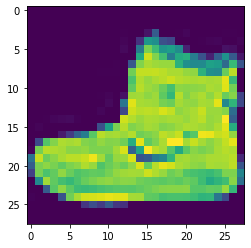

In [6]:
plt.imshow(x_train[0].reshape(28,28))

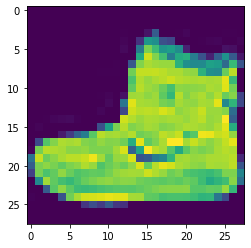

In [7]:
plt.imshow(unnormalize_tanh(normalize_tanh(x_train[0])).reshape(28,28))

In [8]:
# network parameters
width = 28
height = 28
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(7*7*128)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((7,7,128))(x)


    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)



    img_outputs = Conv2D(1,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        73

In [9]:
def build_discriminator():
    inputs = Input(shape=(width,height,1), name='discriminator_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='discriminator')
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
layer_normalization (LayerNo (None, 14, 14, 64)        128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
layer_normalization_1 (Layer (None, 7, 7, 128)         256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)       

In [13]:
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [14]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = discriminator(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_discriminator(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as disc_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        beta = tf.random.uniform(shape=tf.shape(images), minval=0.0, maxval=1.0)
        perturbed_images = images + 0.5 * tf.math.reduce_std(images) * beta
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = perturbed_images - images
        interpolated_images = images + (alpha * diff)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = discriminator(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        disc_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

Iteration [5000/10000]......0.152(s) gen: -183.72829 - disc_fake: 181.46661 - disc_real: 187.77000 - disc_real: 6.30339


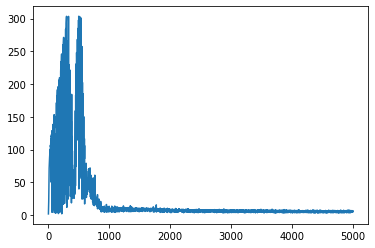

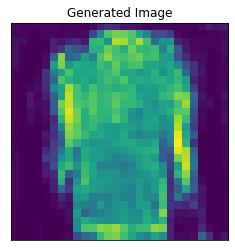

Iteration [5001/10000]......0.126(s) gen: -182.75095 - disc_fake: 181.18533 - disc_real: 187.66697 - disc_real: 6.48164
Iteration [5002/10000]......0.124(s) gen: -184.65479 - disc_fake: 183.87233 - disc_real: 187.74576 - disc_real: 3.87343
Iteration [5003/10000]......0.118(s) gen: -183.41914 - disc_fake: 184.30995 - disc_real: 188.12069 - disc_real: 3.81074
Iteration [5004/10000]......0.114(s) gen: -181.01315 - disc_fake: 182.49556 - disc_real: 187.63273 - disc_real: 5.13717
Iteration [5005/10000]......0.112(s) gen: -180.76865 - disc_fake: 181.14353 - disc_real: 186.90089 - disc_real: 5.75736
Iteration [5006/10000]......0.113(s) gen: -182.57509 - disc_fake: 180.78042 - disc_real: 186.65513 - disc_real: 5.87471
Iteration [5007/10000]......0.112(s) gen: -177.67618 - disc_fake: 182.62207 - disc_real: 187.64976 - disc_real: 5.02769
Iteration [5008/10000]......0.117(s) gen: -182.52554 - disc_fake: 182.18156 - disc_real: 187.21637 - disc_real: 5.03481
Iteration [5009/10000]......0.114(s) gen

Iteration [5070/10000]......0.113(s) gen: -183.30780 - disc_fake: 181.14205 - disc_real: 187.50931 - disc_real: 6.36726
Iteration [5071/10000]......0.112(s) gen: -179.82089 - disc_fake: 182.54851 - disc_real: 187.66545 - disc_real: 5.11694
Iteration [5072/10000]......0.113(s) gen: -181.91312 - disc_fake: 180.66224 - disc_real: 187.29865 - disc_real: 6.63640
Iteration [5073/10000]......0.113(s) gen: -181.81169 - disc_fake: 181.50405 - disc_real: 186.71401 - disc_real: 5.20996
Iteration [5074/10000]......0.113(s) gen: -179.71837 - disc_fake: 181.08442 - disc_real: 186.32090 - disc_real: 5.23647
Iteration [5075/10000]......0.113(s) gen: -183.86400 - disc_fake: 179.73598 - disc_real: 187.39184 - disc_real: 7.65585
Iteration [5076/10000]......0.113(s) gen: -183.92316 - disc_fake: 184.10527 - disc_real: 187.53632 - disc_real: 3.43105
Iteration [5077/10000]......0.112(s) gen: -184.31516 - disc_fake: 184.39410 - disc_real: 188.39966 - disc_real: 4.00556
Iteration [5078/10000]......0.114(s) gen

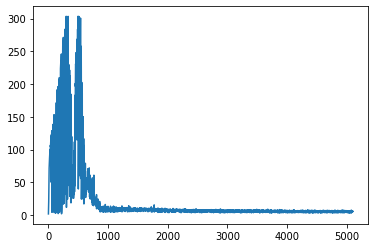

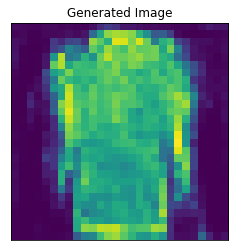

Iteration [5101/10000]......0.114(s) gen: -184.71417 - disc_fake: 185.02572 - disc_real: 188.59217 - disc_real: 3.56645
Iteration [5102/10000]......0.113(s) gen: -179.19705 - disc_fake: 182.58252 - disc_real: 187.23084 - disc_real: 4.64832
Iteration [5103/10000]......0.114(s) gen: -181.44714 - disc_fake: 181.58801 - disc_real: 186.32643 - disc_real: 4.73842
Iteration [5104/10000]......0.113(s) gen: -181.16570 - disc_fake: 180.79792 - disc_real: 186.24326 - disc_real: 5.44534
Iteration [5105/10000]......0.113(s) gen: -183.90590 - disc_fake: 181.98003 - disc_real: 187.41114 - disc_real: 5.43111
Iteration [5106/10000]......0.113(s) gen: -180.84839 - disc_fake: 183.18047 - disc_real: 188.60187 - disc_real: 5.42140
Iteration [5107/10000]......0.115(s) gen: -183.53088 - disc_fake: 182.01095 - disc_real: 187.51135 - disc_real: 5.50040
Iteration [5108/10000]......0.114(s) gen: -183.21658 - disc_fake: 183.63419 - disc_real: 187.98001 - disc_real: 4.34582
Iteration [5109/10000]......0.115(s) gen

Iteration [5170/10000]......0.116(s) gen: -181.23285 - disc_fake: 180.70836 - disc_real: 186.32611 - disc_real: 5.61776
Iteration [5171/10000]......0.114(s) gen: -181.85547 - disc_fake: 181.80738 - disc_real: 187.74503 - disc_real: 5.93765
Iteration [5172/10000]......0.113(s) gen: -183.77866 - disc_fake: 181.57791 - disc_real: 187.53633 - disc_real: 5.95842
Iteration [5173/10000]......0.113(s) gen: -182.56042 - disc_fake: 182.57294 - disc_real: 187.48627 - disc_real: 4.91333
Iteration [5174/10000]......0.114(s) gen: -184.19208 - disc_fake: 181.86871 - disc_real: 187.28613 - disc_real: 5.41742
Iteration [5175/10000]......0.113(s) gen: -183.63892 - disc_fake: 184.35232 - disc_real: 188.07822 - disc_real: 3.72590
Iteration [5176/10000]......0.115(s) gen: -181.92012 - disc_fake: 183.06385 - disc_real: 187.52664 - disc_real: 4.46279
Iteration [5177/10000]......0.114(s) gen: -180.46674 - disc_fake: 181.59475 - disc_real: 187.03717 - disc_real: 5.44242
Iteration [5178/10000]......0.114(s) gen

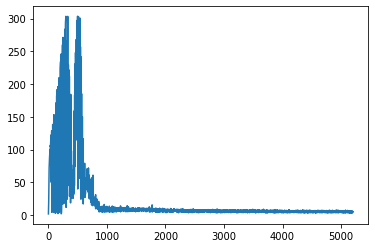

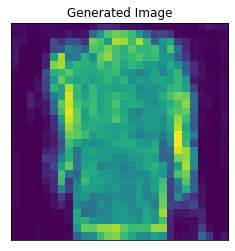

Iteration [5201/10000]......0.115(s) gen: -182.69113 - disc_fake: 182.67468 - disc_real: 188.20282 - disc_real: 5.52814
Iteration [5202/10000]......0.114(s) gen: -180.41080 - disc_fake: 182.27445 - disc_real: 187.55654 - disc_real: 5.28209
Iteration [5203/10000]......0.113(s) gen: -182.25848 - disc_fake: 181.82466 - disc_real: 187.66564 - disc_real: 5.84098
Iteration [5204/10000]......0.114(s) gen: -184.72717 - disc_fake: 181.66012 - disc_real: 187.87696 - disc_real: 6.21684
Iteration [5205/10000]......0.114(s) gen: -178.61406 - disc_fake: 183.36780 - disc_real: 188.11676 - disc_real: 4.74896
Iteration [5206/10000]......0.112(s) gen: -182.72336 - disc_fake: 183.05331 - disc_real: 187.50142 - disc_real: 4.44811
Iteration [5207/10000]......0.114(s) gen: -181.30547 - disc_fake: 182.63026 - disc_real: 187.48683 - disc_real: 4.85657
Iteration [5208/10000]......0.113(s) gen: -182.33925 - disc_fake: 183.35233 - disc_real: 188.76587 - disc_real: 5.41354
Iteration [5209/10000]......0.114(s) gen

Iteration [5270/10000]......0.112(s) gen: -184.16658 - disc_fake: 182.83549 - disc_real: 188.69674 - disc_real: 5.86124
Iteration [5271/10000]......0.113(s) gen: -180.32170 - disc_fake: 183.03315 - disc_real: 188.27084 - disc_real: 5.23769
Iteration [5272/10000]......0.115(s) gen: -182.02515 - disc_fake: 182.64905 - disc_real: 188.30518 - disc_real: 5.65612
Iteration [5273/10000]......0.114(s) gen: -184.29404 - disc_fake: 181.98311 - disc_real: 188.27245 - disc_real: 6.28934
Iteration [5274/10000]......0.112(s) gen: -185.07275 - disc_fake: 182.74651 - disc_real: 188.86027 - disc_real: 6.11375
Iteration [5275/10000]......0.115(s) gen: -183.48459 - disc_fake: 184.83656 - disc_real: 189.31225 - disc_real: 4.47569
Iteration [5276/10000]......0.113(s) gen: -182.24226 - disc_fake: 182.45673 - disc_real: 187.86555 - disc_real: 5.40882
Iteration [5277/10000]......0.114(s) gen: -183.85327 - disc_fake: 182.35671 - disc_real: 188.03000 - disc_real: 5.67329
Iteration [5278/10000]......0.115(s) gen

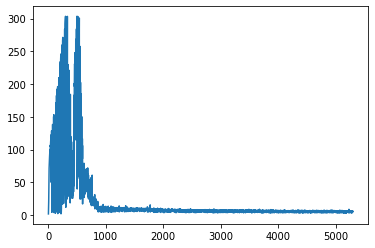

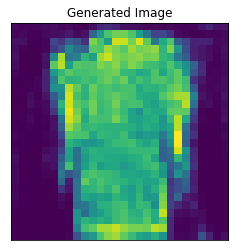

Iteration [5301/10000]......0.135(s) gen: -182.71109 - disc_fake: 184.97098 - disc_real: 189.16443 - disc_real: 4.19345
Iteration [5302/10000]......0.127(s) gen: -182.02867 - disc_fake: 181.60171 - disc_real: 187.83564 - disc_real: 6.23393
Iteration [5303/10000]......0.121(s) gen: -182.87555 - disc_fake: 182.60975 - disc_real: 188.49269 - disc_real: 5.88294
Iteration [5304/10000]......0.118(s) gen: -184.45419 - disc_fake: 181.92642 - disc_real: 188.64575 - disc_real: 6.71933
Iteration [5305/10000]......0.114(s) gen: -183.52817 - disc_fake: 184.58770 - disc_real: 188.50092 - disc_real: 3.91322
Iteration [5306/10000]......0.114(s) gen: -181.85443 - disc_fake: 182.05275 - disc_real: 187.22015 - disc_real: 5.16740
Iteration [5307/10000]......0.113(s) gen: -183.22449 - disc_fake: 182.78385 - disc_real: 188.42806 - disc_real: 5.64421
Iteration [5308/10000]......0.114(s) gen: -183.42664 - disc_fake: 182.42747 - disc_real: 188.03737 - disc_real: 5.60990
Iteration [5309/10000]......0.114(s) gen

Iteration [5370/10000]......0.113(s) gen: -180.00960 - disc_fake: 181.11986 - disc_real: 186.46604 - disc_real: 5.34618
Iteration [5371/10000]......0.115(s) gen: -183.61212 - disc_fake: 180.88256 - disc_real: 186.44304 - disc_real: 5.56048
Iteration [5372/10000]......0.114(s) gen: -183.03983 - disc_fake: 182.81143 - disc_real: 188.08948 - disc_real: 5.27805
Iteration [5373/10000]......0.112(s) gen: -182.69238 - disc_fake: 181.56808 - disc_real: 186.75458 - disc_real: 5.18650
Iteration [5374/10000]......0.114(s) gen: -182.18137 - disc_fake: 182.36733 - disc_real: 187.74807 - disc_real: 5.38073
Iteration [5375/10000]......0.115(s) gen: -182.06100 - disc_fake: 182.02207 - disc_real: 187.47475 - disc_real: 5.45268
Iteration [5376/10000]......0.114(s) gen: -180.77078 - disc_fake: 182.32169 - disc_real: 187.64204 - disc_real: 5.32035
Iteration [5377/10000]......0.114(s) gen: -183.40833 - disc_fake: 180.36438 - disc_real: 186.13937 - disc_real: 5.77499
Iteration [5378/10000]......0.114(s) gen

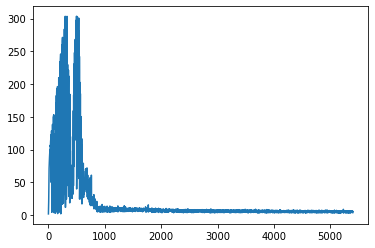

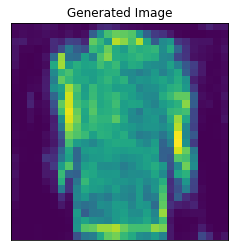

Iteration [5401/10000]......0.114(s) gen: -180.39261 - disc_fake: 182.58390 - disc_real: 187.44919 - disc_real: 4.86529
Iteration [5402/10000]......0.116(s) gen: -180.57246 - disc_fake: 181.44124 - disc_real: 186.82440 - disc_real: 5.38316
Iteration [5403/10000]......0.117(s) gen: -181.34357 - disc_fake: 181.64265 - disc_real: 186.60089 - disc_real: 4.95824
Iteration [5404/10000]......0.115(s) gen: -179.39540 - disc_fake: 181.31720 - disc_real: 186.80409 - disc_real: 5.48689
Iteration [5405/10000]......0.117(s) gen: -184.24872 - disc_fake: 183.79630 - disc_real: 188.49886 - disc_real: 4.70256
Iteration [5406/10000]......0.117(s) gen: -180.10168 - disc_fake: 182.38903 - disc_real: 187.80632 - disc_real: 5.41729
Iteration [5407/10000]......0.114(s) gen: -182.86519 - disc_fake: 181.85046 - disc_real: 186.71270 - disc_real: 4.86224
Iteration [5408/10000]......0.119(s) gen: -184.11263 - disc_fake: 181.04707 - disc_real: 187.32109 - disc_real: 6.27402
Iteration [5409/10000]......0.114(s) gen

Iteration [5470/10000]......0.119(s) gen: -183.95830 - disc_fake: 182.73076 - disc_real: 188.10506 - disc_real: 5.37430
Iteration [5471/10000]......0.120(s) gen: -181.72931 - disc_fake: 183.10033 - disc_real: 188.19490 - disc_real: 5.09457
Iteration [5472/10000]......0.120(s) gen: -183.15910 - disc_fake: 183.07196 - disc_real: 188.65613 - disc_real: 5.58417
Iteration [5473/10000]......0.121(s) gen: -183.49994 - disc_fake: 181.84418 - disc_real: 187.88113 - disc_real: 6.03695
Iteration [5474/10000]......0.120(s) gen: -182.97086 - disc_fake: 182.51414 - disc_real: 187.65302 - disc_real: 5.13888
Iteration [5475/10000]......0.123(s) gen: -184.00476 - disc_fake: 181.62336 - disc_real: 187.27095 - disc_real: 5.64759
Iteration [5476/10000]......0.120(s) gen: -181.83679 - disc_fake: 182.38543 - disc_real: 187.49618 - disc_real: 5.11075
Iteration [5477/10000]......0.119(s) gen: -183.83231 - disc_fake: 183.11425 - disc_real: 188.04362 - disc_real: 4.92937
Iteration [5478/10000]......0.120(s) gen

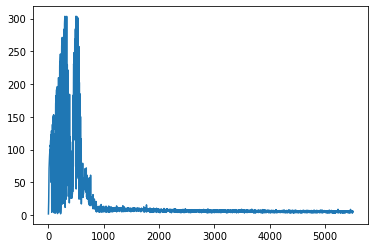

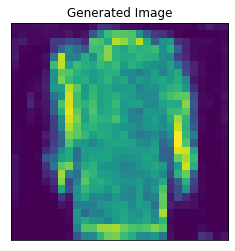

Iteration [5501/10000]......0.115(s) gen: -180.94815 - disc_fake: 182.01531 - disc_real: 187.28912 - disc_real: 5.27381
Iteration [5502/10000]......0.116(s) gen: -182.42136 - disc_fake: 182.02975 - disc_real: 187.69388 - disc_real: 5.66413
Iteration [5503/10000]......0.116(s) gen: -183.30826 - disc_fake: 184.02621 - disc_real: 188.75169 - disc_real: 4.72548
Iteration [5504/10000]......0.115(s) gen: -179.86607 - disc_fake: 182.19706 - disc_real: 187.29856 - disc_real: 5.10149
Iteration [5505/10000]......0.115(s) gen: -183.64729 - disc_fake: 181.99620 - disc_real: 188.05994 - disc_real: 6.06374
Iteration [5506/10000]......0.116(s) gen: -182.39293 - disc_fake: 182.66241 - disc_real: 187.96152 - disc_real: 5.29911
Iteration [5507/10000]......0.116(s) gen: -184.05960 - disc_fake: 181.54420 - disc_real: 186.78356 - disc_real: 5.23936
Iteration [5508/10000]......0.118(s) gen: -180.74057 - disc_fake: 183.21913 - disc_real: 187.88272 - disc_real: 4.66359
Iteration [5509/10000]......0.116(s) gen

Iteration [5570/10000]......0.121(s) gen: -182.67734 - disc_fake: 184.03510 - disc_real: 188.80488 - disc_real: 4.76978
Iteration [5571/10000]......0.119(s) gen: -180.82182 - disc_fake: 182.06348 - disc_real: 187.32038 - disc_real: 5.25690
Iteration [5572/10000]......0.125(s) gen: -181.39539 - disc_fake: 181.55990 - disc_real: 186.35177 - disc_real: 4.79187
Iteration [5573/10000]......0.121(s) gen: -182.99648 - disc_fake: 181.23187 - disc_real: 187.08250 - disc_real: 5.85063
Iteration [5574/10000]......0.122(s) gen: -182.20432 - disc_fake: 180.78503 - disc_real: 186.95988 - disc_real: 6.17485
Iteration [5575/10000]......0.122(s) gen: -181.12247 - disc_fake: 182.49666 - disc_real: 187.12813 - disc_real: 4.63147
Iteration [5576/10000]......0.121(s) gen: -180.19447 - disc_fake: 181.19663 - disc_real: 186.84949 - disc_real: 5.65286
Iteration [5577/10000]......0.122(s) gen: -183.91452 - disc_fake: 179.37942 - disc_real: 187.47089 - disc_real: 8.09147
Iteration [5578/10000]......0.121(s) gen

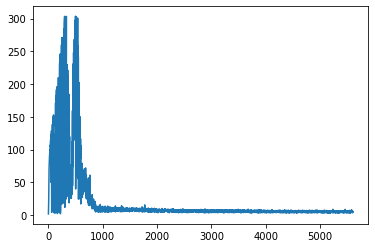

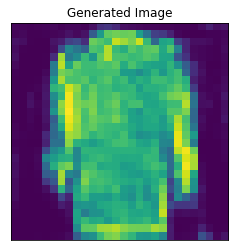

Iteration [5601/10000]......0.122(s) gen: -181.90649 - disc_fake: 182.09833 - disc_real: 187.44943 - disc_real: 5.35110
Iteration [5602/10000]......0.116(s) gen: -181.99214 - disc_fake: 181.24459 - disc_real: 187.18174 - disc_real: 5.93715
Iteration [5603/10000]......0.114(s) gen: -184.13139 - disc_fake: 182.31049 - disc_real: 187.41552 - disc_real: 5.10502
Iteration [5604/10000]......0.115(s) gen: -181.59238 - disc_fake: 182.13190 - disc_real: 187.83625 - disc_real: 5.70435
Iteration [5605/10000]......0.119(s) gen: -180.94385 - disc_fake: 181.91000 - disc_real: 187.76635 - disc_real: 5.85634
Iteration [5606/10000]......0.117(s) gen: -182.12399 - disc_fake: 180.82753 - disc_real: 186.89849 - disc_real: 6.07097
Iteration [5607/10000]......0.116(s) gen: -181.63466 - disc_fake: 181.30583 - disc_real: 187.75115 - disc_real: 6.44533
Iteration [5608/10000]......0.116(s) gen: -183.65024 - disc_fake: 182.00614 - disc_real: 187.85759 - disc_real: 5.85145
Iteration [5609/10000]......0.119(s) gen

Iteration [5670/10000]......0.117(s) gen: -181.52278 - disc_fake: 181.27103 - disc_real: 187.22221 - disc_real: 5.95118
Iteration [5671/10000]......0.117(s) gen: -180.01343 - disc_fake: 181.62841 - disc_real: 187.75347 - disc_real: 6.12506
Iteration [5672/10000]......0.118(s) gen: -182.83417 - disc_fake: 183.44787 - disc_real: 188.10673 - disc_real: 4.65886
Iteration [5673/10000]......0.117(s) gen: -182.32874 - disc_fake: 181.79614 - disc_real: 186.56982 - disc_real: 4.77368
Iteration [5674/10000]......0.118(s) gen: -181.85016 - disc_fake: 181.36124 - disc_real: 187.08816 - disc_real: 5.72692
Iteration [5675/10000]......0.120(s) gen: -184.12750 - disc_fake: 182.12083 - disc_real: 188.64512 - disc_real: 6.52429
Iteration [5676/10000]......0.122(s) gen: -180.54608 - disc_fake: 182.88634 - disc_real: 187.64390 - disc_real: 4.75757
Iteration [5677/10000]......0.121(s) gen: -184.14496 - disc_fake: 181.14043 - disc_real: 187.50329 - disc_real: 6.36285
Iteration [5678/10000]......0.122(s) gen

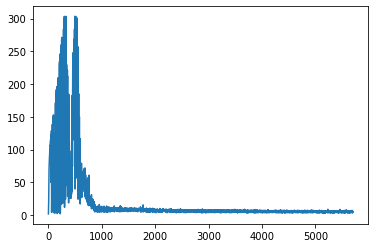

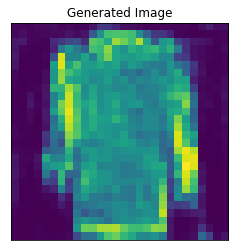

Iteration [5701/10000]......0.115(s) gen: -182.32893 - disc_fake: 182.12688 - disc_real: 186.79001 - disc_real: 4.66313
Iteration [5702/10000]......0.114(s) gen: -182.87393 - disc_fake: 183.08298 - disc_real: 187.82100 - disc_real: 4.73802
Iteration [5703/10000]......0.114(s) gen: -183.86531 - disc_fake: 182.83330 - disc_real: 188.57802 - disc_real: 5.74472
Iteration [5704/10000]......0.117(s) gen: -183.81906 - disc_fake: 182.94446 - disc_real: 189.11422 - disc_real: 6.16976
Iteration [5705/10000]......0.118(s) gen: -182.17159 - disc_fake: 182.67322 - disc_real: 188.32036 - disc_real: 5.64714
Iteration [5706/10000]......0.116(s) gen: -185.49861 - disc_fake: 183.96539 - disc_real: 188.82736 - disc_real: 4.86197
Iteration [5707/10000]......0.115(s) gen: -183.37784 - disc_fake: 184.68976 - disc_real: 188.81286 - disc_real: 4.12310
Iteration [5708/10000]......0.114(s) gen: -180.63013 - disc_fake: 181.87152 - disc_real: 186.54579 - disc_real: 4.67427
Iteration [5709/10000]......0.116(s) gen

Iteration [5770/10000]......0.121(s) gen: -183.88129 - disc_fake: 183.95188 - disc_real: 188.14607 - disc_real: 4.19419
Iteration [5771/10000]......0.120(s) gen: -182.15242 - disc_fake: 183.21341 - disc_real: 187.43343 - disc_real: 4.22002
Iteration [5772/10000]......0.121(s) gen: -185.02124 - disc_fake: 181.73140 - disc_real: 188.30341 - disc_real: 6.57201
Iteration [5773/10000]......0.119(s) gen: -182.00647 - disc_fake: 183.75318 - disc_real: 188.91698 - disc_real: 5.16380
Iteration [5774/10000]......0.120(s) gen: -182.31001 - disc_fake: 183.07226 - disc_real: 188.52624 - disc_real: 5.45398
Iteration [5775/10000]......0.125(s) gen: -180.52286 - disc_fake: 182.78680 - disc_real: 188.02366 - disc_real: 5.23686
Iteration [5776/10000]......0.123(s) gen: -185.05646 - disc_fake: 181.70788 - disc_real: 187.73191 - disc_real: 6.02403
Iteration [5777/10000]......0.120(s) gen: -181.42502 - disc_fake: 183.78076 - disc_real: 188.50561 - disc_real: 4.72485
Iteration [5778/10000]......0.123(s) gen

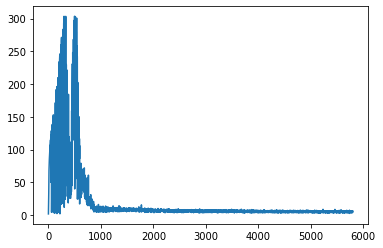

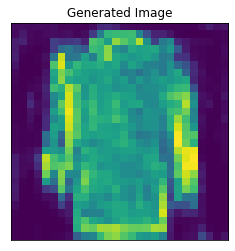

Iteration [5801/10000]......0.121(s) gen: -184.19894 - disc_fake: 183.97513 - disc_real: 187.52742 - disc_real: 3.55229
Iteration [5802/10000]......0.119(s) gen: -183.87898 - disc_fake: 184.45905 - disc_real: 187.63840 - disc_real: 3.17936
Iteration [5803/10000]......0.115(s) gen: -181.73598 - disc_fake: 182.88465 - disc_real: 187.30409 - disc_real: 4.41944
Iteration [5804/10000]......0.116(s) gen: -180.20187 - disc_fake: 180.51705 - disc_real: 185.42802 - disc_real: 4.91097
Iteration [5805/10000]......0.114(s) gen: -180.78740 - disc_fake: 181.42522 - disc_real: 185.96729 - disc_real: 4.54207
Iteration [5806/10000]......0.116(s) gen: -181.31659 - disc_fake: 180.11879 - disc_real: 185.13920 - disc_real: 5.02041
Iteration [5807/10000]......0.118(s) gen: -184.06502 - disc_fake: 181.62063 - disc_real: 187.01136 - disc_real: 5.39073
Iteration [5808/10000]......0.116(s) gen: -182.89597 - disc_fake: 183.00376 - disc_real: 188.25630 - disc_real: 5.25253
Iteration [5809/10000]......0.115(s) gen

Iteration [5870/10000]......0.120(s) gen: -184.41840 - disc_fake: 185.34349 - disc_real: 188.78027 - disc_real: 3.43678
Iteration [5871/10000]......0.120(s) gen: -182.44687 - disc_fake: 183.88765 - disc_real: 188.21327 - disc_real: 4.32562
Iteration [5872/10000]......0.120(s) gen: -182.50403 - disc_fake: 181.62505 - disc_real: 186.39379 - disc_real: 4.76874
Iteration [5873/10000]......0.119(s) gen: -180.88379 - disc_fake: 182.23969 - disc_real: 187.63317 - disc_real: 5.39348
Iteration [5874/10000]......0.118(s) gen: -181.72015 - disc_fake: 182.26763 - disc_real: 187.72217 - disc_real: 5.45454
Iteration [5875/10000]......0.121(s) gen: -183.01083 - disc_fake: 182.29624 - disc_real: 188.51913 - disc_real: 6.22290
Iteration [5876/10000]......0.122(s) gen: -185.32393 - disc_fake: 182.89067 - disc_real: 188.13598 - disc_real: 5.24531
Iteration [5877/10000]......0.123(s) gen: -184.97610 - disc_fake: 185.31754 - disc_real: 189.37890 - disc_real: 4.06136
Iteration [5878/10000]......0.124(s) gen

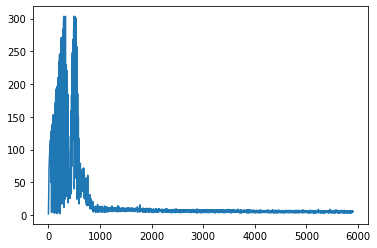

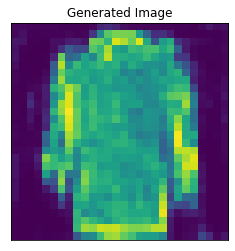

Iteration [5901/10000]......0.121(s) gen: -184.19987 - disc_fake: 185.99873 - disc_real: 188.91353 - disc_real: 2.91479
Iteration [5902/10000]......0.134(s) gen: -183.18866 - disc_fake: 183.03248 - disc_real: 187.46162 - disc_real: 4.42914
Iteration [5903/10000]......0.138(s) gen: -181.24265 - disc_fake: 182.31990 - disc_real: 187.51244 - disc_real: 5.19253
Iteration [5904/10000]......0.135(s) gen: -182.51456 - disc_fake: 183.10890 - disc_real: 188.12747 - disc_real: 5.01858
Iteration [5905/10000]......0.139(s) gen: -183.31793 - disc_fake: 182.42515 - disc_real: 187.17147 - disc_real: 4.74632
Iteration [5906/10000]......0.137(s) gen: -185.48862 - disc_fake: 182.12701 - disc_real: 187.90926 - disc_real: 5.78225
Iteration [5907/10000]......0.138(s) gen: -186.10300 - disc_fake: 186.13991 - disc_real: 189.56546 - disc_real: 3.42554
Iteration [5908/10000]......0.138(s) gen: -183.50977 - disc_fake: 185.54984 - disc_real: 189.52860 - disc_real: 3.97876
Iteration [5909/10000]......0.136(s) gen

Iteration [5970/10000]......0.119(s) gen: -180.93790 - disc_fake: 181.30501 - disc_real: 185.71064 - disc_real: 4.40564
Iteration [5971/10000]......0.123(s) gen: -180.33229 - disc_fake: 179.93869 - disc_real: 185.58614 - disc_real: 5.64745
Iteration [5972/10000]......0.121(s) gen: -181.63397 - disc_fake: 180.93787 - disc_real: 186.74556 - disc_real: 5.80769
Iteration [5973/10000]......0.116(s) gen: -182.62025 - disc_fake: 181.85946 - disc_real: 187.19045 - disc_real: 5.33099
Iteration [5974/10000]......0.117(s) gen: -183.03983 - disc_fake: 182.27872 - disc_real: 187.50938 - disc_real: 5.23067
Iteration [5975/10000]......0.116(s) gen: -183.70132 - disc_fake: 182.20294 - disc_real: 188.43120 - disc_real: 6.22826
Iteration [5976/10000]......0.116(s) gen: -183.16083 - disc_fake: 183.13900 - disc_real: 188.36266 - disc_real: 5.22367
Iteration [5977/10000]......0.114(s) gen: -183.82812 - disc_fake: 183.21816 - disc_real: 188.68636 - disc_real: 5.46820
Iteration [5978/10000]......0.116(s) gen

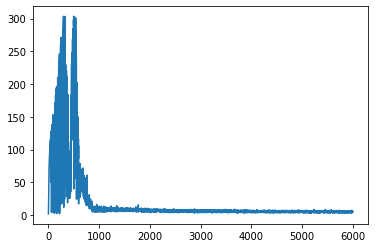

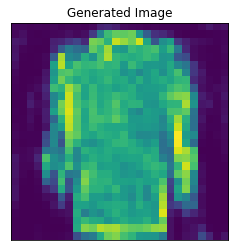

checkpointing at epoch: 6000
Iteration [6001/10000]......0.116(s) gen: -182.53775 - disc_fake: 182.64959 - disc_real: 187.81532 - disc_real: 5.16573
Iteration [6002/10000]......0.117(s) gen: -184.70868 - disc_fake: 184.12186 - disc_real: 189.48179 - disc_real: 5.35993
Iteration [6003/10000]......0.118(s) gen: -182.01541 - disc_fake: 183.81193 - disc_real: 189.07204 - disc_real: 5.26011
Iteration [6004/10000]......0.115(s) gen: -184.76920 - disc_fake: 182.93513 - disc_real: 188.88956 - disc_real: 5.95443
Iteration [6005/10000]......0.116(s) gen: -182.61696 - disc_fake: 184.19089 - disc_real: 189.25302 - disc_real: 5.06213
Iteration [6006/10000]......0.117(s) gen: -181.64497 - disc_fake: 181.63954 - disc_real: 188.06360 - disc_real: 6.42407
Iteration [6007/10000]......0.117(s) gen: -185.29500 - disc_fake: 185.07403 - disc_real: 189.26541 - disc_real: 4.19138
Iteration [6008/10000]......0.116(s) gen: -182.62494 - disc_fake: 184.64428 - disc_real: 188.62881 - disc_real: 3.98453
Iteration [

Iteration [6070/10000]......0.119(s) gen: -181.95178 - disc_fake: 183.86164 - disc_real: 189.19725 - disc_real: 5.33561
Iteration [6071/10000]......0.122(s) gen: -185.74240 - disc_fake: 184.94391 - disc_real: 189.79142 - disc_real: 4.84752
Iteration [6072/10000]......0.121(s) gen: -182.65668 - disc_fake: 184.90197 - disc_real: 189.51169 - disc_real: 4.60972
Iteration [6073/10000]......0.120(s) gen: -184.81799 - disc_fake: 183.43652 - disc_real: 188.37010 - disc_real: 4.93358
Iteration [6074/10000]......0.121(s) gen: -184.26682 - disc_fake: 183.64216 - disc_real: 188.77938 - disc_real: 5.13722
Iteration [6075/10000]......0.117(s) gen: -185.12411 - disc_fake: 182.72610 - disc_real: 187.95869 - disc_real: 5.23259
Iteration [6076/10000]......0.118(s) gen: -186.26399 - disc_fake: 185.56042 - disc_real: 189.21158 - disc_real: 3.65116
Iteration [6077/10000]......0.118(s) gen: -183.49875 - disc_fake: 185.31251 - disc_real: 189.32825 - disc_real: 4.01574
Iteration [6078/10000]......0.122(s) gen

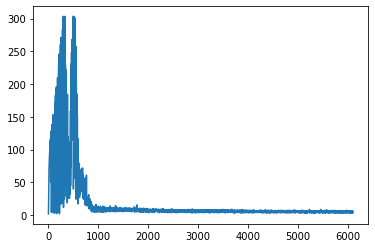

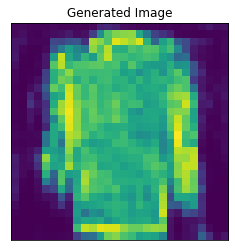

Iteration [6101/10000]......0.119(s) gen: -181.01649 - disc_fake: 183.37635 - disc_real: 188.22289 - disc_real: 4.84653
Iteration [6102/10000]......0.116(s) gen: -183.27370 - disc_fake: 181.65548 - disc_real: 186.82639 - disc_real: 5.17090
Iteration [6103/10000]......0.115(s) gen: -181.13211 - disc_fake: 182.58732 - disc_real: 187.59752 - disc_real: 5.01020
Iteration [6104/10000]......0.120(s) gen: -180.30064 - disc_fake: 181.81945 - disc_real: 187.69060 - disc_real: 5.87115
Iteration [6105/10000]......0.117(s) gen: -182.72217 - disc_fake: 182.04558 - disc_real: 187.63969 - disc_real: 5.59412
Iteration [6106/10000]......0.116(s) gen: -182.01888 - disc_fake: 183.14731 - disc_real: 188.53850 - disc_real: 5.39119
Iteration [6107/10000]......0.118(s) gen: -183.78223 - disc_fake: 183.47773 - disc_real: 188.63749 - disc_real: 5.15975
Iteration [6108/10000]......0.120(s) gen: -182.51657 - disc_fake: 183.35848 - disc_real: 188.60238 - disc_real: 5.24390
Iteration [6109/10000]......0.120(s) gen

Iteration [6170/10000]......0.119(s) gen: -184.85890 - disc_fake: 185.24907 - disc_real: 188.81427 - disc_real: 3.56520
Iteration [6171/10000]......0.119(s) gen: -183.60626 - disc_fake: 184.70302 - disc_real: 188.55235 - disc_real: 3.84933
Iteration [6172/10000]......0.117(s) gen: -183.43555 - disc_fake: 183.83599 - disc_real: 188.39899 - disc_real: 4.56300
Iteration [6173/10000]......0.121(s) gen: -181.93152 - disc_fake: 183.42963 - disc_real: 188.63362 - disc_real: 5.20399
Iteration [6174/10000]......0.122(s) gen: -182.30560 - disc_fake: 183.49448 - disc_real: 188.56278 - disc_real: 5.06830
Iteration [6175/10000]......0.119(s) gen: -185.58597 - disc_fake: 182.84934 - disc_real: 188.42826 - disc_real: 5.57892
Iteration [6176/10000]......0.120(s) gen: -183.88780 - disc_fake: 184.45941 - disc_real: 189.32748 - disc_real: 4.86806
Iteration [6177/10000]......0.122(s) gen: -181.29259 - disc_fake: 183.50333 - disc_real: 189.15489 - disc_real: 5.65156
Iteration [6178/10000]......0.121(s) gen

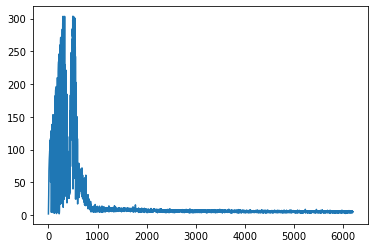

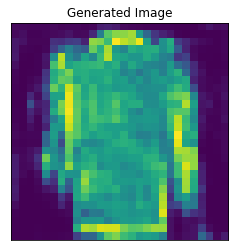

Iteration [6201/10000]......0.115(s) gen: -185.34084 - disc_fake: 183.33411 - disc_real: 188.86437 - disc_real: 5.53026
Iteration [6202/10000]......0.117(s) gen: -184.16220 - disc_fake: 185.18706 - disc_real: 189.45443 - disc_real: 4.26736
Iteration [6203/10000]......0.118(s) gen: -184.78888 - disc_fake: 183.80535 - disc_real: 188.99553 - disc_real: 5.19019
Iteration [6204/10000]......0.119(s) gen: -184.68484 - disc_fake: 185.24588 - disc_real: 189.26136 - disc_real: 4.01548
Iteration [6205/10000]......0.118(s) gen: -182.70782 - disc_fake: 183.59677 - disc_real: 188.16638 - disc_real: 4.56961
Iteration [6206/10000]......0.120(s) gen: -186.15125 - disc_fake: 182.32954 - disc_real: 188.22552 - disc_real: 5.89598
Iteration [6207/10000]......0.123(s) gen: -185.87534 - disc_fake: 185.81534 - disc_real: 189.23169 - disc_real: 3.41636
Iteration [6208/10000]......0.120(s) gen: -181.68835 - disc_fake: 184.30509 - disc_real: 188.59695 - disc_real: 4.29186
Iteration [6209/10000]......0.118(s) gen

Iteration [6270/10000]......0.120(s) gen: -184.42838 - disc_fake: 184.34170 - disc_real: 189.37578 - disc_real: 5.03408
Iteration [6271/10000]......0.116(s) gen: -183.00943 - disc_fake: 184.37935 - disc_real: 189.53420 - disc_real: 5.15485
Iteration [6272/10000]......0.117(s) gen: -183.58147 - disc_fake: 184.90158 - disc_real: 189.87549 - disc_real: 4.97391
Iteration [6273/10000]......0.116(s) gen: -181.07556 - disc_fake: 183.32209 - disc_real: 189.02024 - disc_real: 5.69814
Iteration [6274/10000]......0.118(s) gen: -185.11716 - disc_fake: 183.95720 - disc_real: 188.72137 - disc_real: 4.76417
Iteration [6275/10000]......0.118(s) gen: -184.04156 - disc_fake: 185.15691 - disc_real: 188.97180 - disc_real: 3.81489
Iteration [6276/10000]......0.122(s) gen: -183.19989 - disc_fake: 182.11885 - disc_real: 188.07225 - disc_real: 5.95340
Iteration [6277/10000]......0.122(s) gen: -180.97864 - disc_fake: 183.41827 - disc_real: 189.22927 - disc_real: 5.81100
Iteration [6278/10000]......0.122(s) gen

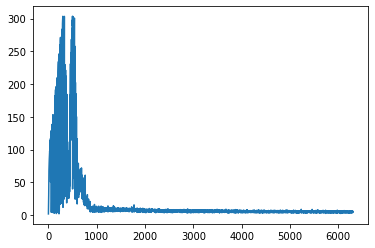

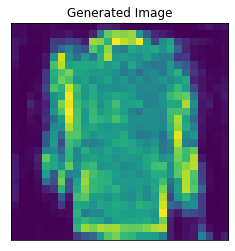

Iteration [6301/10000]......0.118(s) gen: -183.66422 - disc_fake: 183.62796 - disc_real: 188.95796 - disc_real: 5.33000
Iteration [6302/10000]......0.116(s) gen: -184.84346 - disc_fake: 184.18147 - disc_real: 189.52701 - disc_real: 5.34554
Iteration [6303/10000]......0.116(s) gen: -185.64436 - disc_fake: 184.57520 - disc_real: 188.99587 - disc_real: 4.42068
Iteration [6304/10000]......0.118(s) gen: -186.81065 - disc_fake: 186.99814 - disc_real: 190.21453 - disc_real: 3.21639
Iteration [6305/10000]......0.118(s) gen: -182.09113 - disc_fake: 185.74633 - disc_real: 189.45735 - disc_real: 3.71103
Iteration [6306/10000]......0.116(s) gen: -184.32062 - disc_fake: 184.06356 - disc_real: 188.15861 - disc_real: 4.09505
Iteration [6307/10000]......0.116(s) gen: -182.13115 - disc_fake: 183.36452 - disc_real: 188.04989 - disc_real: 4.68537
Iteration [6308/10000]......0.118(s) gen: -183.79091 - disc_fake: 181.65823 - disc_real: 187.44062 - disc_real: 5.78239
Iteration [6309/10000]......0.118(s) gen

Iteration [6370/10000]......0.116(s) gen: -185.96878 - disc_fake: 183.42236 - disc_real: 188.84521 - disc_real: 5.42285
Iteration [6371/10000]......0.115(s) gen: -184.15645 - disc_fake: 185.51695 - disc_real: 189.80382 - disc_real: 4.28687
Iteration [6372/10000]......0.114(s) gen: -183.52824 - disc_fake: 183.84698 - disc_real: 189.22502 - disc_real: 5.37804
Iteration [6373/10000]......0.115(s) gen: -181.63058 - disc_fake: 183.20000 - disc_real: 188.97337 - disc_real: 5.77337
Iteration [6374/10000]......0.115(s) gen: -186.58833 - disc_fake: 184.74132 - disc_real: 188.92705 - disc_real: 4.18573
Iteration [6375/10000]......0.115(s) gen: -186.82253 - disc_fake: 186.91847 - disc_real: 190.21471 - disc_real: 3.29624
Iteration [6376/10000]......0.117(s) gen: -185.64709 - disc_fake: 186.61324 - disc_real: 190.05633 - disc_real: 3.44308
Iteration [6377/10000]......0.116(s) gen: -183.30429 - disc_fake: 185.01010 - disc_real: 188.29824 - disc_real: 3.28814
Iteration [6378/10000]......0.117(s) gen

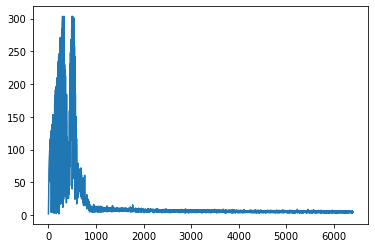

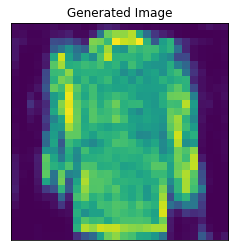

Iteration [6401/10000]......0.118(s) gen: -180.12732 - disc_fake: 183.91461 - disc_real: 188.21229 - disc_real: 4.29768
Iteration [6402/10000]......0.113(s) gen: -183.49486 - disc_fake: 182.96033 - disc_real: 188.02759 - disc_real: 5.06725
Iteration [6403/10000]......0.117(s) gen: -183.69441 - disc_fake: 183.02383 - disc_real: 188.05551 - disc_real: 5.03167
Iteration [6404/10000]......0.116(s) gen: -182.52428 - disc_fake: 182.49252 - disc_real: 188.16417 - disc_real: 5.67165
Iteration [6405/10000]......0.116(s) gen: -184.64549 - disc_fake: 183.75430 - disc_real: 188.39916 - disc_real: 4.64486
Iteration [6406/10000]......0.118(s) gen: -185.26581 - disc_fake: 184.63882 - disc_real: 189.16358 - disc_real: 4.52476
Iteration [6407/10000]......0.119(s) gen: -182.54327 - disc_fake: 184.66808 - disc_real: 189.93521 - disc_real: 5.26712
Iteration [6408/10000]......0.119(s) gen: -179.47061 - disc_fake: 183.22368 - disc_real: 188.27159 - disc_real: 5.04790
Iteration [6409/10000]......0.117(s) gen

Iteration [6470/10000]......0.117(s) gen: -185.33305 - disc_fake: 182.48160 - disc_real: 188.05099 - disc_real: 5.56939
Iteration [6471/10000]......0.117(s) gen: -185.07394 - disc_fake: 184.99938 - disc_real: 188.76356 - disc_real: 3.76418
Iteration [6472/10000]......0.117(s) gen: -181.50655 - disc_fake: 183.82472 - disc_real: 188.81529 - disc_real: 4.99057
Iteration [6473/10000]......0.117(s) gen: -180.51862 - disc_fake: 182.69702 - disc_real: 188.23183 - disc_real: 5.53481
Iteration [6474/10000]......0.116(s) gen: -183.19083 - disc_fake: 183.44828 - disc_real: 188.74858 - disc_real: 5.30030
Iteration [6475/10000]......0.118(s) gen: -185.57053 - disc_fake: 182.15657 - disc_real: 189.20469 - disc_real: 7.04812
Iteration [6476/10000]......0.116(s) gen: -182.29785 - disc_fake: 184.40076 - disc_real: 189.00977 - disc_real: 4.60901
Iteration [6477/10000]......0.118(s) gen: -183.31137 - disc_fake: 183.75077 - disc_real: 188.64195 - disc_real: 4.89118
Iteration [6478/10000]......0.118(s) gen

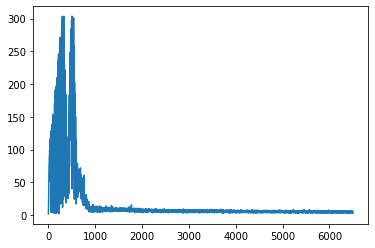

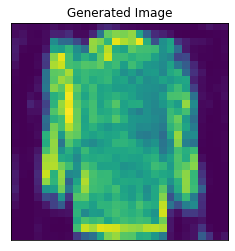

Iteration [6501/10000]......0.115(s) gen: -183.70541 - disc_fake: 184.44657 - disc_real: 188.30489 - disc_real: 3.85832
Iteration [6502/10000]......0.115(s) gen: -183.53851 - disc_fake: 183.58895 - disc_real: 187.34190 - disc_real: 3.75294
Iteration [6503/10000]......0.116(s) gen: -183.81937 - disc_fake: 183.82095 - disc_real: 188.10333 - disc_real: 4.28238
Iteration [6504/10000]......0.117(s) gen: -183.77850 - disc_fake: 183.79866 - disc_real: 188.18735 - disc_real: 4.38870
Iteration [6505/10000]......0.118(s) gen: -184.20883 - disc_fake: 183.11951 - disc_real: 187.98922 - disc_real: 4.86971
Iteration [6506/10000]......0.119(s) gen: -184.92233 - disc_fake: 185.13362 - disc_real: 189.64088 - disc_real: 4.50726
Iteration [6507/10000]......0.116(s) gen: -182.18129 - disc_fake: 183.11217 - disc_real: 187.50606 - disc_real: 4.39388
Iteration [6508/10000]......0.116(s) gen: -183.68501 - disc_fake: 182.60248 - disc_real: 188.05628 - disc_real: 5.45380
Iteration [6509/10000]......0.118(s) gen

Iteration [6570/10000]......0.127(s) gen: -186.04317 - disc_fake: 185.57118 - disc_real: 188.54651 - disc_real: 2.97534
Iteration [6571/10000]......0.122(s) gen: -185.76141 - disc_fake: 185.83459 - disc_real: 189.14904 - disc_real: 3.31445
Iteration [6572/10000]......0.121(s) gen: -183.28435 - disc_fake: 183.86052 - disc_real: 188.14492 - disc_real: 4.28440
Iteration [6573/10000]......0.120(s) gen: -182.94559 - disc_fake: 183.17618 - disc_real: 187.05910 - disc_real: 3.88292
Iteration [6574/10000]......0.121(s) gen: -183.07219 - disc_fake: 182.74677 - disc_real: 187.22651 - disc_real: 4.47975
Iteration [6575/10000]......0.121(s) gen: -181.88486 - disc_fake: 182.74213 - disc_real: 187.46433 - disc_real: 4.72221
Iteration [6576/10000]......0.121(s) gen: -183.71658 - disc_fake: 183.57466 - disc_real: 188.45023 - disc_real: 4.87556
Iteration [6577/10000]......0.121(s) gen: -184.39282 - disc_fake: 183.84215 - disc_real: 188.95349 - disc_real: 5.11133
Iteration [6578/10000]......0.120(s) gen

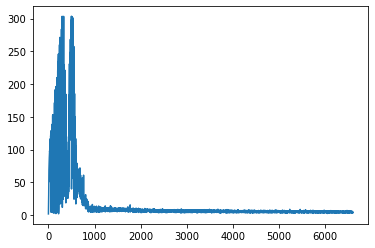

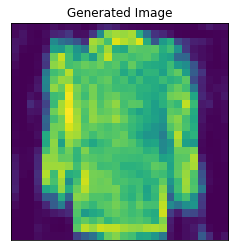

Iteration [6601/10000]......0.136(s) gen: -185.26128 - disc_fake: 187.33909 - disc_real: 190.77684 - disc_real: 3.43775
Iteration [6602/10000]......0.118(s) gen: -183.10313 - disc_fake: 184.27683 - disc_real: 188.39200 - disc_real: 4.11517
Iteration [6603/10000]......0.115(s) gen: -182.30396 - disc_fake: 182.39143 - disc_real: 187.59907 - disc_real: 5.20763
Iteration [6604/10000]......0.117(s) gen: -183.57921 - disc_fake: 183.20685 - disc_real: 188.21405 - disc_real: 5.00720
Iteration [6605/10000]......0.118(s) gen: -183.90903 - disc_fake: 183.93661 - disc_real: 188.83885 - disc_real: 4.90223
Iteration [6606/10000]......0.117(s) gen: -184.85046 - disc_fake: 184.58347 - disc_real: 189.47514 - disc_real: 4.89167
Iteration [6607/10000]......0.115(s) gen: -183.07765 - disc_fake: 184.58676 - disc_real: 189.57558 - disc_real: 4.98882
Iteration [6608/10000]......0.118(s) gen: -183.06985 - disc_fake: 183.71006 - disc_real: 189.62474 - disc_real: 5.91468
Iteration [6609/10000]......0.118(s) gen

Iteration [6670/10000]......0.122(s) gen: -185.02887 - disc_fake: 185.64885 - disc_real: 189.19879 - disc_real: 3.54995
Iteration [6671/10000]......0.124(s) gen: -183.48418 - disc_fake: 183.95252 - disc_real: 187.98016 - disc_real: 4.02764
Iteration [6672/10000]......0.120(s) gen: -182.62408 - disc_fake: 183.17914 - disc_real: 187.17780 - disc_real: 3.99866
Iteration [6673/10000]......0.121(s) gen: -183.39059 - disc_fake: 183.28737 - disc_real: 187.35567 - disc_real: 4.06830
Iteration [6674/10000]......0.120(s) gen: -183.19501 - disc_fake: 182.84677 - disc_real: 187.45478 - disc_real: 4.60800
Iteration [6675/10000]......0.122(s) gen: -183.72589 - disc_fake: 183.61113 - disc_real: 188.39372 - disc_real: 4.78259
Iteration [6676/10000]......0.120(s) gen: -183.70410 - disc_fake: 183.15421 - disc_real: 188.47556 - disc_real: 5.32135
Iteration [6677/10000]......0.121(s) gen: -185.33130 - disc_fake: 184.48395 - disc_real: 189.92487 - disc_real: 5.44091
Iteration [6678/10000]......0.119(s) gen

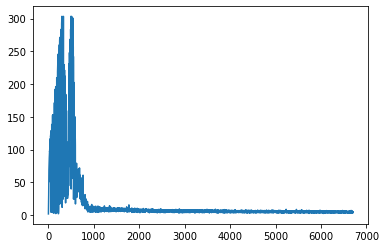

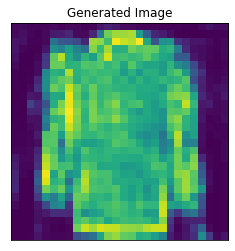

Iteration [6701/10000]......0.125(s) gen: -185.67459 - disc_fake: 184.33500 - disc_real: 189.81072 - disc_real: 5.47572
Iteration [6702/10000]......0.124(s) gen: -186.62579 - disc_fake: 186.00918 - disc_real: 189.38848 - disc_real: 3.37930
Iteration [6703/10000]......0.117(s) gen: -185.52579 - disc_fake: 186.79493 - disc_real: 190.19713 - disc_real: 3.40220
Iteration [6704/10000]......0.123(s) gen: -183.72273 - disc_fake: 184.93763 - disc_real: 188.89200 - disc_real: 3.95437
Iteration [6705/10000]......0.132(s) gen: -184.13197 - disc_fake: 183.44265 - disc_real: 188.63237 - disc_real: 5.18972
Iteration [6706/10000]......0.119(s) gen: -185.12753 - disc_fake: 184.00090 - disc_real: 188.45119 - disc_real: 4.45029
Iteration [6707/10000]......0.118(s) gen: -182.90198 - disc_fake: 184.18676 - disc_real: 188.84942 - disc_real: 4.66265
Iteration [6708/10000]......0.120(s) gen: -184.12909 - disc_fake: 183.92723 - disc_real: 188.69974 - disc_real: 4.77251
Iteration [6709/10000]......0.118(s) gen

Iteration [6770/10000]......0.118(s) gen: -184.50282 - disc_fake: 184.90805 - disc_real: 189.86176 - disc_real: 4.95371
Iteration [6771/10000]......0.120(s) gen: -184.40640 - disc_fake: 185.55615 - disc_real: 190.01037 - disc_real: 4.45422
Iteration [6772/10000]......0.123(s) gen: -186.42691 - disc_fake: 184.92826 - disc_real: 189.37140 - disc_real: 4.44314
Iteration [6773/10000]......0.121(s) gen: -182.71695 - disc_fake: 185.71484 - disc_real: 190.34503 - disc_real: 4.63019
Iteration [6774/10000]......0.122(s) gen: -185.90723 - disc_fake: 184.55198 - disc_real: 189.33262 - disc_real: 4.78064
Iteration [6775/10000]......0.122(s) gen: -184.12608 - disc_fake: 184.69481 - disc_real: 189.24340 - disc_real: 4.54858
Iteration [6776/10000]......0.117(s) gen: -183.48116 - disc_fake: 184.03295 - disc_real: 188.98291 - disc_real: 4.94996
Iteration [6777/10000]......0.124(s) gen: -184.48337 - disc_fake: 184.45595 - disc_real: 188.94084 - disc_real: 4.48489
Iteration [6778/10000]......0.119(s) gen

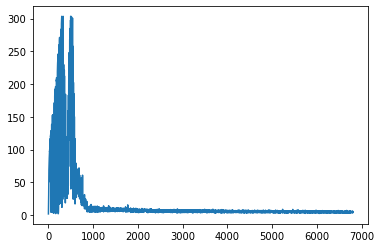

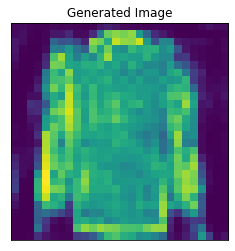

Iteration [6801/10000]......0.124(s) gen: -182.94751 - disc_fake: 185.32683 - disc_real: 190.11144 - disc_real: 4.78461
Iteration [6802/10000]......0.132(s) gen: -184.57564 - disc_fake: 183.95759 - disc_real: 189.33691 - disc_real: 5.37932
Iteration [6803/10000]......0.136(s) gen: -184.51703 - disc_fake: 184.27258 - disc_real: 188.89473 - disc_real: 4.62215
Iteration [6804/10000]......0.135(s) gen: -180.26303 - disc_fake: 183.99010 - disc_real: 189.28849 - disc_real: 5.29839
Iteration [6805/10000]......0.137(s) gen: -187.07986 - disc_fake: 185.91499 - disc_real: 189.86916 - disc_real: 3.95417
Iteration [6806/10000]......0.139(s) gen: -185.56197 - disc_fake: 186.60066 - disc_real: 190.52054 - disc_real: 3.91988
Iteration [6807/10000]......0.135(s) gen: -183.60800 - disc_fake: 184.94272 - disc_real: 189.74339 - disc_real: 4.80067
Iteration [6808/10000]......0.135(s) gen: -182.77423 - disc_fake: 184.30035 - disc_real: 189.53300 - disc_real: 5.23265
Iteration [6809/10000]......0.138(s) gen

Iteration [6870/10000]......0.116(s) gen: -185.92715 - disc_fake: 184.61992 - disc_real: 189.85699 - disc_real: 5.23707
Iteration [6871/10000]......0.117(s) gen: -186.47504 - disc_fake: 186.59372 - disc_real: 189.52790 - disc_real: 2.93418
Iteration [6872/10000]......0.117(s) gen: -186.37914 - disc_fake: 187.19898 - disc_real: 189.65223 - disc_real: 2.45325
Iteration [6873/10000]......0.117(s) gen: -184.35037 - disc_fake: 185.38549 - disc_real: 188.67197 - disc_real: 3.28647
Iteration [6874/10000]......0.116(s) gen: -181.88455 - disc_fake: 182.87656 - disc_real: 187.10340 - disc_real: 4.22684
Iteration [6875/10000]......0.117(s) gen: -182.19951 - disc_fake: 181.03534 - disc_real: 185.78364 - disc_real: 4.74831
Iteration [6876/10000]......0.118(s) gen: -181.20102 - disc_fake: 182.09169 - disc_real: 186.84342 - disc_real: 4.75173
Iteration [6877/10000]......0.117(s) gen: -182.84851 - disc_fake: 182.93502 - disc_real: 187.13898 - disc_real: 4.20396
Iteration [6878/10000]......0.117(s) gen

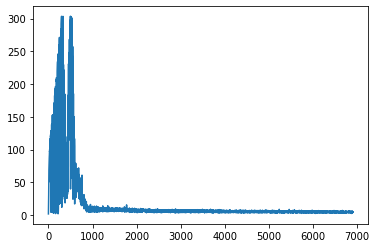

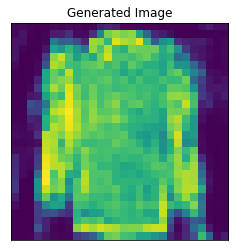

Iteration [6901/10000]......0.121(s) gen: -176.28738 - disc_fake: 182.36117 - disc_real: 189.05590 - disc_real: 6.69474
Iteration [6902/10000]......0.119(s) gen: -186.22678 - disc_fake: 184.23607 - disc_real: 189.13884 - disc_real: 4.90277
Iteration [6903/10000]......0.116(s) gen: -186.97672 - disc_fake: 186.76396 - disc_real: 189.39785 - disc_real: 2.63389
Iteration [6904/10000]......0.116(s) gen: -187.46741 - disc_fake: 187.56383 - disc_real: 190.67449 - disc_real: 3.11066
Iteration [6905/10000]......0.116(s) gen: -187.39160 - disc_fake: 187.51490 - disc_real: 190.82549 - disc_real: 3.31059
Iteration [6906/10000]......0.117(s) gen: -185.60281 - disc_fake: 186.44226 - disc_real: 190.16693 - disc_real: 3.72466
Iteration [6907/10000]......0.116(s) gen: -183.94794 - disc_fake: 185.00916 - disc_real: 189.10843 - disc_real: 4.09927
Iteration [6908/10000]......0.116(s) gen: -183.08023 - disc_fake: 183.89729 - disc_real: 188.15282 - disc_real: 4.25553
Iteration [6909/10000]......0.117(s) gen

Iteration [6970/10000]......0.119(s) gen: -186.51935 - disc_fake: 184.80077 - disc_real: 190.40475 - disc_real: 5.60398
Iteration [6971/10000]......0.117(s) gen: -185.82431 - disc_fake: 185.17705 - disc_real: 190.03313 - disc_real: 4.85608
Iteration [6972/10000]......0.117(s) gen: -183.94377 - disc_fake: 185.48409 - disc_real: 190.42658 - disc_real: 4.94249
Iteration [6973/10000]......0.120(s) gen: -184.08899 - disc_fake: 184.77922 - disc_real: 190.17439 - disc_real: 5.39516
Iteration [6974/10000]......0.118(s) gen: -185.86591 - disc_fake: 185.15058 - disc_real: 189.76044 - disc_real: 4.60985
Iteration [6975/10000]......0.116(s) gen: -184.23274 - disc_fake: 185.59842 - disc_real: 189.42867 - disc_real: 3.83025
Iteration [6976/10000]......0.117(s) gen: -183.90955 - disc_fake: 184.41633 - disc_real: 188.74658 - disc_real: 4.33025
Iteration [6977/10000]......0.117(s) gen: -181.63495 - disc_fake: 183.29142 - disc_real: 189.00620 - disc_real: 5.71478
Iteration [6978/10000]......0.118(s) gen

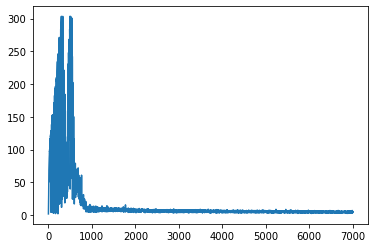

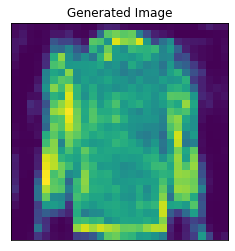

Iteration [7001/10000]......0.114(s) gen: -184.83093 - disc_fake: 183.99816 - disc_real: 188.50052 - disc_real: 4.50237
Iteration [7002/10000]......0.115(s) gen: -181.90526 - disc_fake: 184.05659 - disc_real: 189.06096 - disc_real: 5.00438
Iteration [7003/10000]......0.115(s) gen: -186.42596 - disc_fake: 183.07494 - disc_real: 189.03242 - disc_real: 5.95749
Iteration [7004/10000]......0.117(s) gen: -186.99734 - disc_fake: 186.72599 - disc_real: 189.62446 - disc_real: 2.89847
Iteration [7005/10000]......0.118(s) gen: -187.16434 - disc_fake: 187.39496 - disc_real: 190.81053 - disc_real: 3.41557
Iteration [7006/10000]......0.119(s) gen: -186.72630 - disc_fake: 187.33259 - disc_real: 190.77112 - disc_real: 3.43852
Iteration [7007/10000]......0.115(s) gen: -184.82520 - disc_fake: 186.15086 - disc_real: 189.44985 - disc_real: 3.29899
Iteration [7008/10000]......0.114(s) gen: -184.28758 - disc_fake: 184.41940 - disc_real: 188.15661 - disc_real: 3.73721
Iteration [7009/10000]......0.114(s) gen

Iteration [7070/10000]......0.119(s) gen: -182.73897 - disc_fake: 183.84730 - disc_real: 188.83707 - disc_real: 4.98977
Iteration [7071/10000]......0.118(s) gen: -183.31848 - disc_fake: 184.38963 - disc_real: 188.72688 - disc_real: 4.33725
Iteration [7072/10000]......0.122(s) gen: -181.62701 - disc_fake: 183.37570 - disc_real: 188.71577 - disc_real: 5.34008
Iteration [7073/10000]......0.121(s) gen: -181.21548 - disc_fake: 183.21085 - disc_real: 188.44869 - disc_real: 5.23785
Iteration [7074/10000]......0.120(s) gen: -181.44308 - disc_fake: 182.14803 - disc_real: 187.22508 - disc_real: 5.07706
Iteration [7075/10000]......0.120(s) gen: -184.28180 - disc_fake: 184.19806 - disc_real: 188.77959 - disc_real: 4.58153
Iteration [7076/10000]......0.124(s) gen: -185.90604 - disc_fake: 184.04682 - disc_real: 189.51225 - disc_real: 5.46544
Iteration [7077/10000]......0.118(s) gen: -183.32715 - disc_fake: 184.18011 - disc_real: 189.00185 - disc_real: 4.82174
Iteration [7078/10000]......0.120(s) gen

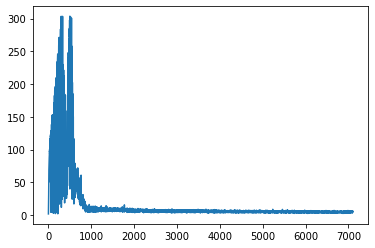

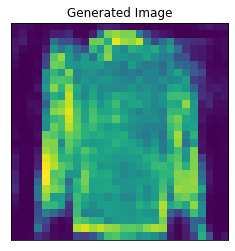

Iteration [7101/10000]......0.119(s) gen: -187.06406 - disc_fake: 185.68361 - disc_real: 189.66191 - disc_real: 3.97830
Iteration [7102/10000]......0.119(s) gen: -187.23639 - disc_fake: 187.62564 - disc_real: 190.57868 - disc_real: 2.95304
Iteration [7103/10000]......0.118(s) gen: -185.64162 - disc_fake: 186.91772 - disc_real: 190.60338 - disc_real: 3.68566
Iteration [7104/10000]......0.118(s) gen: -183.30121 - disc_fake: 183.99688 - disc_real: 188.00885 - disc_real: 4.01198
Iteration [7105/10000]......0.118(s) gen: -184.00243 - disc_fake: 183.81904 - disc_real: 188.05622 - disc_real: 4.23718
Iteration [7106/10000]......0.121(s) gen: -182.75290 - disc_fake: 183.63613 - disc_real: 188.66049 - disc_real: 5.02436
Iteration [7107/10000]......0.118(s) gen: -185.42734 - disc_fake: 182.64447 - disc_real: 188.82180 - disc_real: 6.17733
Iteration [7108/10000]......0.119(s) gen: -184.95816 - disc_fake: 184.94917 - disc_real: 189.07422 - disc_real: 4.12505
Iteration [7109/10000]......0.120(s) gen

Iteration [7170/10000]......0.118(s) gen: -183.70616 - disc_fake: 184.49691 - disc_real: 189.37276 - disc_real: 4.87585
Iteration [7171/10000]......0.118(s) gen: -184.21344 - disc_fake: 184.08351 - disc_real: 189.16533 - disc_real: 5.08182
Iteration [7172/10000]......0.119(s) gen: -185.41400 - disc_fake: 184.38038 - disc_real: 189.67815 - disc_real: 5.29777
Iteration [7173/10000]......0.117(s) gen: -183.85403 - disc_fake: 184.27984 - disc_real: 189.32376 - disc_real: 5.04392
Iteration [7174/10000]......0.119(s) gen: -186.17307 - disc_fake: 184.94641 - disc_real: 189.81140 - disc_real: 4.86499
Iteration [7175/10000]......0.117(s) gen: -186.38309 - disc_fake: 186.49308 - disc_real: 189.86386 - disc_real: 3.37078
Iteration [7176/10000]......0.119(s) gen: -182.96315 - disc_fake: 185.16698 - disc_real: 188.73499 - disc_real: 3.56800
Iteration [7177/10000]......0.119(s) gen: -181.07112 - disc_fake: 182.43193 - disc_real: 187.31516 - disc_real: 4.88323
Iteration [7178/10000]......0.118(s) gen

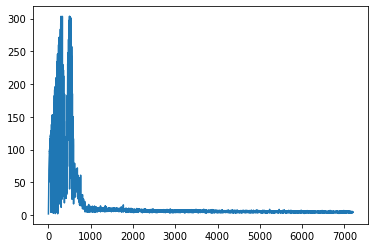

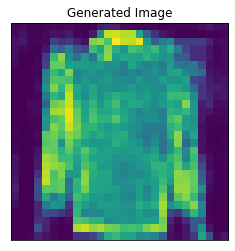

Iteration [7201/10000]......0.115(s) gen: -183.26505 - disc_fake: 184.19227 - disc_real: 188.21024 - disc_real: 4.01797
Iteration [7202/10000]......0.115(s) gen: -185.42020 - disc_fake: 183.47119 - disc_real: 188.34554 - disc_real: 4.87436
Iteration [7203/10000]......0.114(s) gen: -186.68201 - disc_fake: 185.06303 - disc_real: 189.78900 - disc_real: 4.72597
Iteration [7204/10000]......0.116(s) gen: -187.60907 - disc_fake: 187.61245 - disc_real: 190.90599 - disc_real: 3.29354
Iteration [7205/10000]......0.115(s) gen: -185.18967 - disc_fake: 186.68628 - disc_real: 190.57894 - disc_real: 3.89266
Iteration [7206/10000]......0.114(s) gen: -183.66687 - disc_fake: 184.19117 - disc_real: 188.39151 - disc_real: 4.20034
Iteration [7207/10000]......0.115(s) gen: -184.09009 - disc_fake: 183.82120 - disc_real: 188.40762 - disc_real: 4.58642
Iteration [7208/10000]......0.115(s) gen: -184.91698 - disc_fake: 183.10215 - disc_real: 187.95530 - disc_real: 4.85316
Iteration [7209/10000]......0.114(s) gen

Iteration [7270/10000]......0.120(s) gen: -186.34885 - disc_fake: 184.44729 - disc_real: 189.98399 - disc_real: 5.53670
Iteration [7271/10000]......0.119(s) gen: -186.73778 - disc_fake: 186.55206 - disc_real: 189.57743 - disc_real: 3.02537
Iteration [7272/10000]......0.118(s) gen: -185.13333 - disc_fake: 186.81695 - disc_real: 189.60906 - disc_real: 2.79211
Iteration [7273/10000]......0.121(s) gen: -182.76047 - disc_fake: 184.32797 - disc_real: 188.15867 - disc_real: 3.83070
Iteration [7274/10000]......0.120(s) gen: -182.03610 - disc_fake: 182.36908 - disc_real: 186.69659 - disc_real: 4.32752
Iteration [7275/10000]......0.121(s) gen: -183.12161 - disc_fake: 183.28174 - disc_real: 187.95787 - disc_real: 4.67613
Iteration [7276/10000]......0.119(s) gen: -182.97496 - disc_fake: 184.42166 - disc_real: 188.87618 - disc_real: 4.45452
Iteration [7277/10000]......0.120(s) gen: -186.42920 - disc_fake: 185.50666 - disc_real: 189.33525 - disc_real: 3.82859
Iteration [7278/10000]......0.121(s) gen

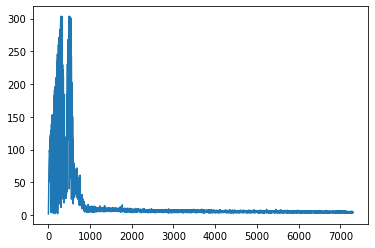

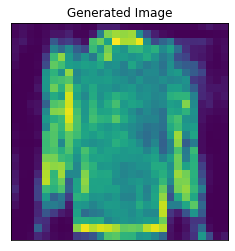

Iteration [7301/10000]......0.122(s) gen: -185.11035 - disc_fake: 184.32575 - disc_real: 189.30248 - disc_real: 4.97673
Iteration [7302/10000]......0.120(s) gen: -185.87271 - disc_fake: 184.96390 - disc_real: 190.06097 - disc_real: 5.09707
Iteration [7303/10000]......0.118(s) gen: -183.22739 - disc_fake: 185.09902 - disc_real: 188.86127 - disc_real: 3.76226
Iteration [7304/10000]......0.119(s) gen: -183.42023 - disc_fake: 183.71609 - disc_real: 188.81474 - disc_real: 5.09864
Iteration [7305/10000]......0.119(s) gen: -185.77528 - disc_fake: 184.54190 - disc_real: 189.30001 - disc_real: 4.75811
Iteration [7306/10000]......0.120(s) gen: -184.84491 - disc_fake: 184.34078 - disc_real: 188.87786 - disc_real: 4.53707
Iteration [7307/10000]......0.119(s) gen: -184.40820 - disc_fake: 184.74352 - disc_real: 188.75053 - disc_real: 4.00702
Iteration [7308/10000]......0.120(s) gen: -185.86937 - disc_fake: 183.64406 - disc_real: 188.04091 - disc_real: 4.39685
Iteration [7309/10000]......0.121(s) gen

Iteration [7370/10000]......0.120(s) gen: -186.01300 - disc_fake: 184.26186 - disc_real: 189.44485 - disc_real: 5.18299
Iteration [7371/10000]......0.118(s) gen: -186.29747 - disc_fake: 186.21777 - disc_real: 189.71651 - disc_real: 3.49875
Iteration [7372/10000]......0.118(s) gen: -184.44197 - disc_fake: 185.63628 - disc_real: 189.47449 - disc_real: 3.83821
Iteration [7373/10000]......0.117(s) gen: -183.32651 - disc_fake: 183.13621 - disc_real: 187.53320 - disc_real: 4.39699
Iteration [7374/10000]......0.118(s) gen: -182.94203 - disc_fake: 182.83736 - disc_real: 188.11353 - disc_real: 5.27617
Iteration [7375/10000]......0.118(s) gen: -182.88547 - disc_fake: 182.97605 - disc_real: 188.35989 - disc_real: 5.38385
Iteration [7376/10000]......0.118(s) gen: -185.30545 - disc_fake: 183.10438 - disc_real: 188.89211 - disc_real: 5.78773
Iteration [7377/10000]......0.116(s) gen: -182.75955 - disc_fake: 185.12621 - disc_real: 189.78520 - disc_real: 4.65898
Iteration [7378/10000]......0.117(s) gen

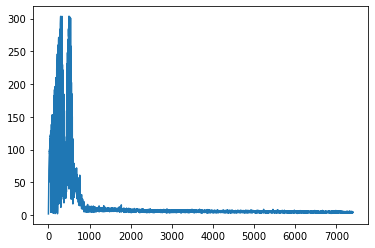

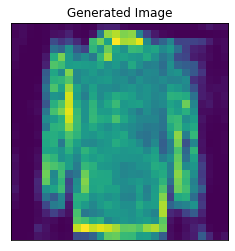

Iteration [7401/10000]......0.122(s) gen: -186.66205 - disc_fake: 185.26603 - disc_real: 188.87601 - disc_real: 3.60998
Iteration [7402/10000]......0.121(s) gen: -185.53149 - disc_fake: 186.17165 - disc_real: 190.02895 - disc_real: 3.85730
Iteration [7403/10000]......0.116(s) gen: -183.32153 - disc_fake: 184.81895 - disc_real: 188.59658 - disc_real: 3.77762
Iteration [7404/10000]......0.116(s) gen: -183.21509 - disc_fake: 183.18764 - disc_real: 188.00063 - disc_real: 4.81299
Iteration [7405/10000]......0.116(s) gen: -182.60748 - disc_fake: 182.63888 - disc_real: 187.74959 - disc_real: 5.11071
Iteration [7406/10000]......0.115(s) gen: -185.19019 - disc_fake: 183.21264 - disc_real: 188.60640 - disc_real: 5.39376
Iteration [7407/10000]......0.116(s) gen: -184.33234 - disc_fake: 183.90681 - disc_real: 188.87691 - disc_real: 4.97009
Iteration [7408/10000]......0.115(s) gen: -183.69113 - disc_fake: 185.42555 - disc_real: 189.68789 - disc_real: 4.26234
Iteration [7409/10000]......0.115(s) gen

Iteration [7470/10000]......0.120(s) gen: -183.59863 - disc_fake: 185.14624 - disc_real: 188.50129 - disc_real: 3.35504
Iteration [7471/10000]......0.122(s) gen: -184.39230 - disc_fake: 183.45099 - disc_real: 188.18982 - disc_real: 4.73883
Iteration [7472/10000]......0.121(s) gen: -184.84305 - disc_fake: 183.59807 - disc_real: 188.33164 - disc_real: 4.73358
Iteration [7473/10000]......0.121(s) gen: -186.46951 - disc_fake: 185.60625 - disc_real: 189.00022 - disc_real: 3.39397
Iteration [7474/10000]......0.118(s) gen: -184.05438 - disc_fake: 185.93354 - disc_real: 189.20984 - disc_real: 3.27631
Iteration [7475/10000]......0.120(s) gen: -183.79874 - disc_fake: 183.54701 - disc_real: 187.63112 - disc_real: 4.08411
Iteration [7476/10000]......0.123(s) gen: -183.57117 - disc_fake: 183.81427 - disc_real: 188.49843 - disc_real: 4.68416
Iteration [7477/10000]......0.123(s) gen: -184.72099 - disc_fake: 184.25252 - disc_real: 189.01476 - disc_real: 4.76225
Iteration [7478/10000]......0.123(s) gen

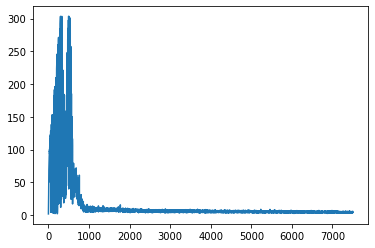

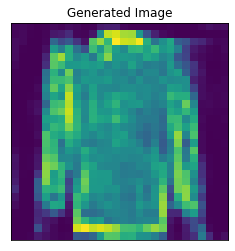

Iteration [7501/10000]......0.122(s) gen: -185.77878 - disc_fake: 185.68102 - disc_real: 190.30865 - disc_real: 4.62763
Iteration [7502/10000]......0.121(s) gen: -183.28995 - disc_fake: 185.38981 - disc_real: 189.80943 - disc_real: 4.41962
Iteration [7503/10000]......0.117(s) gen: -184.19110 - disc_fake: 184.70789 - disc_real: 189.86489 - disc_real: 5.15700
Iteration [7504/10000]......0.117(s) gen: -187.35382 - disc_fake: 186.16241 - disc_real: 190.69248 - disc_real: 4.53008
Iteration [7505/10000]......0.120(s) gen: -184.89630 - disc_fake: 186.54716 - disc_real: 190.53682 - disc_real: 3.98966
Iteration [7506/10000]......0.119(s) gen: -186.52972 - disc_fake: 184.92441 - disc_real: 189.96962 - disc_real: 5.04521
Iteration [7507/10000]......0.116(s) gen: -183.29584 - disc_fake: 185.10781 - disc_real: 188.81509 - disc_real: 3.70728
Iteration [7508/10000]......0.117(s) gen: -183.31747 - disc_fake: 183.56747 - disc_real: 188.82706 - disc_real: 5.25959
Iteration [7509/10000]......0.119(s) gen

Iteration [7570/10000]......0.119(s) gen: -185.35986 - disc_fake: 185.70041 - disc_real: 190.67163 - disc_real: 4.97122
Iteration [7571/10000]......0.120(s) gen: -188.18822 - disc_fake: 186.03662 - disc_real: 190.88090 - disc_real: 4.84428
Iteration [7572/10000]......0.118(s) gen: -186.03932 - disc_fake: 187.08321 - disc_real: 190.83963 - disc_real: 3.75642
Iteration [7573/10000]......0.120(s) gen: -185.37955 - disc_fake: 184.67122 - disc_real: 189.69990 - disc_real: 5.02867
Iteration [7574/10000]......0.118(s) gen: -185.46024 - disc_fake: 184.44041 - disc_real: 189.43472 - disc_real: 4.99431
Iteration [7575/10000]......0.118(s) gen: -184.15732 - disc_fake: 184.30540 - disc_real: 189.21458 - disc_real: 4.90919
Iteration [7576/10000]......0.118(s) gen: -185.95042 - disc_fake: 186.23987 - disc_real: 190.56822 - disc_real: 4.32835
Iteration [7577/10000]......0.119(s) gen: -188.27902 - disc_fake: 187.54499 - disc_real: 190.39868 - disc_real: 2.85369
Iteration [7578/10000]......0.119(s) gen

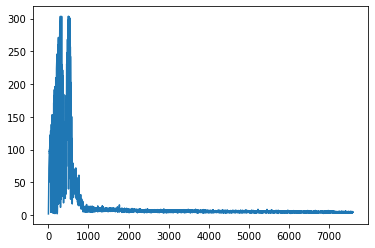

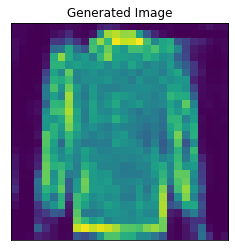

Iteration [7601/10000]......0.115(s) gen: -185.15680 - disc_fake: 184.75213 - disc_real: 189.95938 - disc_real: 5.20725
Iteration [7602/10000]......0.114(s) gen: -186.66728 - disc_fake: 185.55754 - disc_real: 190.01379 - disc_real: 4.45625
Iteration [7603/10000]......0.114(s) gen: -184.54414 - disc_fake: 186.25092 - disc_real: 190.26639 - disc_real: 4.01547
Iteration [7604/10000]......0.114(s) gen: -187.33453 - disc_fake: 186.13484 - disc_real: 191.34502 - disc_real: 5.21018
Iteration [7605/10000]......0.117(s) gen: -184.55768 - disc_fake: 185.29183 - disc_real: 189.17431 - disc_real: 3.88248
Iteration [7606/10000]......0.117(s) gen: -184.78778 - disc_fake: 184.62492 - disc_real: 189.67158 - disc_real: 5.04666
Iteration [7607/10000]......0.114(s) gen: -184.99557 - disc_fake: 185.54456 - disc_real: 190.55890 - disc_real: 5.01434
Iteration [7608/10000]......0.117(s) gen: -186.96741 - disc_fake: 184.35356 - disc_real: 190.10674 - disc_real: 5.75319
Iteration [7609/10000]......0.116(s) gen

Iteration [7670/10000]......0.123(s) gen: -183.20020 - disc_fake: 184.32601 - disc_real: 187.90091 - disc_real: 3.57491
Iteration [7671/10000]......0.124(s) gen: -185.88075 - disc_fake: 183.51948 - disc_real: 188.45488 - disc_real: 4.93541
Iteration [7672/10000]......0.125(s) gen: -185.71527 - disc_fake: 186.34522 - disc_real: 190.06282 - disc_real: 3.71759
Iteration [7673/10000]......0.121(s) gen: -185.17682 - disc_fake: 184.49616 - disc_real: 189.34174 - disc_real: 4.84558
Iteration [7674/10000]......0.125(s) gen: -183.18732 - disc_fake: 184.81150 - disc_real: 188.99203 - disc_real: 4.18053
Iteration [7675/10000]......0.119(s) gen: -182.89809 - disc_fake: 183.44219 - disc_real: 188.97431 - disc_real: 5.53212
Iteration [7676/10000]......0.122(s) gen: -184.74911 - disc_fake: 184.35648 - disc_real: 188.67834 - disc_real: 4.32186
Iteration [7677/10000]......0.121(s) gen: -184.13174 - disc_fake: 184.72108 - disc_real: 188.22230 - disc_real: 3.50122
Iteration [7678/10000]......0.122(s) gen

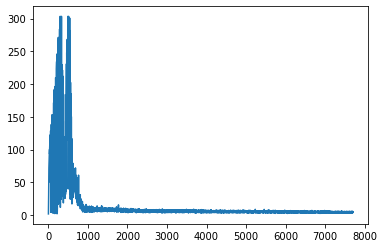

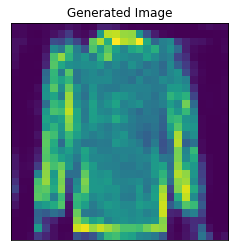

Iteration [7701/10000]......0.126(s) gen: -185.80353 - disc_fake: 185.57891 - disc_real: 190.29089 - disc_real: 4.71198
Iteration [7702/10000]......0.121(s) gen: -185.13110 - disc_fake: 184.81357 - disc_real: 189.34379 - disc_real: 4.53022
Iteration [7703/10000]......0.117(s) gen: -184.34270 - disc_fake: 183.78221 - disc_real: 188.67690 - disc_real: 4.89468
Iteration [7704/10000]......0.120(s) gen: -186.01547 - disc_fake: 185.12650 - disc_real: 189.26781 - disc_real: 4.14131
Iteration [7705/10000]......0.118(s) gen: -186.22629 - disc_fake: 184.10807 - disc_real: 188.95735 - disc_real: 4.84928
Iteration [7706/10000]......0.117(s) gen: -186.62347 - disc_fake: 186.97459 - disc_real: 190.51871 - disc_real: 3.54412
Iteration [7707/10000]......0.118(s) gen: -183.79391 - disc_fake: 184.64065 - disc_real: 188.86123 - disc_real: 4.22058
Iteration [7708/10000]......0.123(s) gen: -184.66602 - disc_fake: 184.03926 - disc_real: 188.55627 - disc_real: 4.51701
Iteration [7709/10000]......0.121(s) gen

Iteration [7770/10000]......0.120(s) gen: -185.35834 - disc_fake: 183.71249 - disc_real: 187.83464 - disc_real: 4.12215
Iteration [7771/10000]......0.119(s) gen: -184.94156 - disc_fake: 184.74798 - disc_real: 189.40250 - disc_real: 4.65452
Iteration [7772/10000]......0.119(s) gen: -185.18719 - disc_fake: 184.06474 - disc_real: 188.78639 - disc_real: 4.72165
Iteration [7773/10000]......0.118(s) gen: -184.50241 - disc_fake: 185.27154 - disc_real: 190.27437 - disc_real: 5.00283
Iteration [7774/10000]......0.120(s) gen: -185.63048 - disc_fake: 184.91559 - disc_real: 189.87219 - disc_real: 4.95660
Iteration [7775/10000]......0.118(s) gen: -184.54764 - disc_fake: 185.96850 - disc_real: 190.57249 - disc_real: 4.60399
Iteration [7776/10000]......0.119(s) gen: -187.38095 - disc_fake: 186.13470 - disc_real: 191.13074 - disc_real: 4.99604
Iteration [7777/10000]......0.118(s) gen: -186.41516 - disc_fake: 186.61058 - disc_real: 191.09998 - disc_real: 4.48939
Iteration [7778/10000]......0.121(s) gen

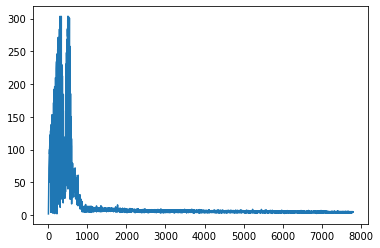

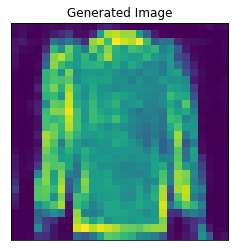

Iteration [7801/10000]......0.119(s) gen: -184.86124 - disc_fake: 185.88168 - disc_real: 190.56992 - disc_real: 4.68824
Iteration [7802/10000]......0.116(s) gen: -185.02679 - disc_fake: 184.75595 - disc_real: 190.62957 - disc_real: 5.87362
Iteration [7803/10000]......0.114(s) gen: -186.66406 - disc_fake: 185.09246 - disc_real: 189.65986 - disc_real: 4.56740
Iteration [7804/10000]......0.116(s) gen: -187.00183 - disc_fake: 186.95135 - disc_real: 190.17520 - disc_real: 3.22386
Iteration [7805/10000]......0.114(s) gen: -185.15356 - disc_fake: 186.35862 - disc_real: 189.85873 - disc_real: 3.50012
Iteration [7806/10000]......0.114(s) gen: -185.21338 - disc_fake: 185.40166 - disc_real: 189.48944 - disc_real: 4.08778
Iteration [7807/10000]......0.114(s) gen: -184.17763 - disc_fake: 183.77355 - disc_real: 188.87662 - disc_real: 5.10307
Iteration [7808/10000]......0.114(s) gen: -183.16109 - disc_fake: 184.09895 - disc_real: 188.35626 - disc_real: 4.25731
Iteration [7809/10000]......0.113(s) gen

Iteration [7870/10000]......0.119(s) gen: -186.99205 - disc_fake: 185.88078 - disc_real: 190.46453 - disc_real: 4.58375
Iteration [7871/10000]......0.117(s) gen: -187.40865 - disc_fake: 187.64569 - disc_real: 190.64398 - disc_real: 2.99828
Iteration [7872/10000]......0.119(s) gen: -184.84085 - disc_fake: 186.68454 - disc_real: 190.09889 - disc_real: 3.41435
Iteration [7873/10000]......0.121(s) gen: -184.24104 - disc_fake: 184.82687 - disc_real: 188.75928 - disc_real: 3.93241
Iteration [7874/10000]......0.118(s) gen: -183.29712 - disc_fake: 182.52859 - disc_real: 187.86050 - disc_real: 5.33190
Iteration [7875/10000]......0.121(s) gen: -184.14667 - disc_fake: 184.24178 - disc_real: 188.59898 - disc_real: 4.35720
Iteration [7876/10000]......0.119(s) gen: -184.33298 - disc_fake: 184.03805 - disc_real: 188.88715 - disc_real: 4.84910
Iteration [7877/10000]......0.121(s) gen: -185.35776 - disc_fake: 184.40323 - disc_real: 188.94505 - disc_real: 4.54182
Iteration [7878/10000]......0.119(s) gen

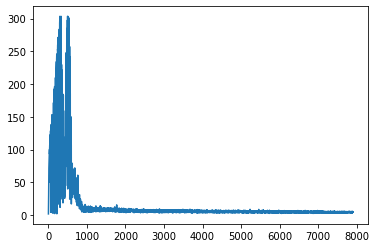

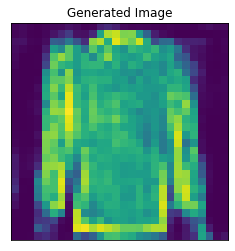

Iteration [7901/10000]......0.122(s) gen: -187.42111 - disc_fake: 186.82937 - disc_real: 191.14463 - disc_real: 4.31526
Iteration [7902/10000]......0.118(s) gen: -185.86142 - disc_fake: 186.74965 - disc_real: 190.93227 - disc_real: 4.18263
Iteration [7903/10000]......0.113(s) gen: -183.13638 - disc_fake: 184.62108 - disc_real: 189.48851 - disc_real: 4.86743
Iteration [7904/10000]......0.113(s) gen: -184.71086 - disc_fake: 182.86254 - disc_real: 189.29210 - disc_real: 6.42957
Iteration [7905/10000]......0.115(s) gen: -185.18051 - disc_fake: 183.86504 - disc_real: 188.64554 - disc_real: 4.78051
Iteration [7906/10000]......0.114(s) gen: -184.59801 - disc_fake: 185.28152 - disc_real: 189.15780 - disc_real: 3.87628
Iteration [7907/10000]......0.116(s) gen: -182.44662 - disc_fake: 184.10875 - disc_real: 188.46926 - disc_real: 4.36052
Iteration [7908/10000]......0.120(s) gen: -185.21994 - disc_fake: 183.63492 - disc_real: 188.04474 - disc_real: 4.40983
Iteration [7909/10000]......0.116(s) gen

Iteration [7970/10000]......0.123(s) gen: -185.59276 - disc_fake: 185.64839 - disc_real: 190.96848 - disc_real: 5.32009
Iteration [7971/10000]......0.122(s) gen: -185.98148 - disc_fake: 185.82995 - disc_real: 190.79479 - disc_real: 4.96484
Iteration [7972/10000]......0.123(s) gen: -183.79239 - disc_fake: 185.55218 - disc_real: 190.00924 - disc_real: 4.45706
Iteration [7973/10000]......0.120(s) gen: -186.58569 - disc_fake: 185.76876 - disc_real: 189.41445 - disc_real: 3.64569
Iteration [7974/10000]......0.121(s) gen: -187.00993 - disc_fake: 187.55666 - disc_real: 190.39009 - disc_real: 2.83343
Iteration [7975/10000]......0.125(s) gen: -185.47923 - disc_fake: 186.93385 - disc_real: 190.31086 - disc_real: 3.37701
Iteration [7976/10000]......0.125(s) gen: -184.77420 - disc_fake: 185.44257 - disc_real: 188.65643 - disc_real: 3.21386
Iteration [7977/10000]......0.123(s) gen: -183.00685 - disc_fake: 183.97700 - disc_real: 188.12011 - disc_real: 4.14311
Iteration [7978/10000]......0.122(s) gen

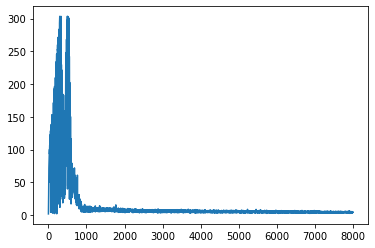

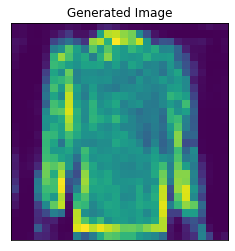

checkpointing at epoch: 8000
Iteration [8001/10000]......0.118(s) gen: -185.84349 - disc_fake: 185.58587 - disc_real: 190.03042 - disc_real: 4.44456
Iteration [8002/10000]......0.121(s) gen: -187.43411 - disc_fake: 187.73010 - disc_real: 191.82336 - disc_real: 4.09326
Iteration [8003/10000]......0.115(s) gen: -186.78937 - disc_fake: 186.47542 - disc_real: 191.26131 - disc_real: 4.78589
Iteration [8004/10000]......0.114(s) gen: -184.10960 - disc_fake: 185.70897 - disc_real: 190.19331 - disc_real: 4.48434
Iteration [8005/10000]......0.115(s) gen: -186.88315 - disc_fake: 185.84258 - disc_real: 190.51788 - disc_real: 4.67530
Iteration [8006/10000]......0.118(s) gen: -185.32013 - disc_fake: 185.76269 - disc_real: 190.18301 - disc_real: 4.42032
Iteration [8007/10000]......0.119(s) gen: -185.59274 - disc_fake: 184.52015 - disc_real: 189.51112 - disc_real: 4.99098
Iteration [8008/10000]......0.120(s) gen: -186.64986 - disc_fake: 185.41634 - disc_real: 189.78617 - disc_real: 4.36983
Iteration [

Iteration [8069/10000]......0.118(s) gen: -184.47679 - disc_fake: 186.14551 - disc_real: 189.60337 - disc_real: 3.45786
Iteration [8070/10000]......0.117(s) gen: -184.75484 - disc_fake: 184.60946 - disc_real: 188.99434 - disc_real: 4.38488
Iteration [8071/10000]......0.118(s) gen: -186.01170 - disc_fake: 185.62383 - disc_real: 189.84818 - disc_real: 4.22435
Iteration [8072/10000]......0.118(s) gen: -184.09181 - disc_fake: 185.78953 - disc_real: 189.87581 - disc_real: 4.08628
Iteration [8073/10000]......0.119(s) gen: -186.67334 - disc_fake: 186.00979 - disc_real: 190.48535 - disc_real: 4.47556
Iteration [8074/10000]......0.117(s) gen: -184.93582 - disc_fake: 185.82478 - disc_real: 190.67324 - disc_real: 4.84846
Iteration [8075/10000]......0.118(s) gen: -188.81659 - disc_fake: 186.33676 - disc_real: 191.16243 - disc_real: 4.82567
Iteration [8076/10000]......0.118(s) gen: -187.71515 - disc_fake: 188.60724 - disc_real: 191.43780 - disc_real: 2.83056
Iteration [8077/10000]......0.122(s) gen

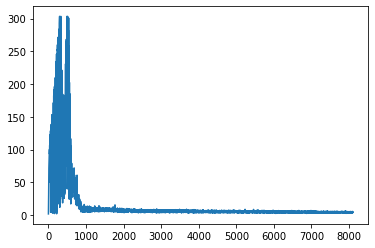

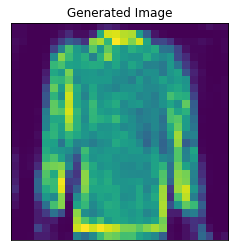

Iteration [8101/10000]......0.124(s) gen: -187.67818 - disc_fake: 188.78447 - disc_real: 191.60479 - disc_real: 2.82032
Iteration [8102/10000]......0.119(s) gen: -183.43088 - disc_fake: 186.17561 - disc_real: 190.14930 - disc_real: 3.97369
Iteration [8103/10000]......0.116(s) gen: -182.86862 - disc_fake: 184.09988 - disc_real: 188.83203 - disc_real: 4.73215
Iteration [8104/10000]......0.117(s) gen: -183.77200 - disc_fake: 183.75121 - disc_real: 188.13210 - disc_real: 4.38090
Iteration [8105/10000]......0.119(s) gen: -186.07973 - disc_fake: 183.56986 - disc_real: 189.54236 - disc_real: 5.97250
Iteration [8106/10000]......0.122(s) gen: -185.31796 - disc_fake: 186.41086 - disc_real: 190.40505 - disc_real: 3.99419
Iteration [8107/10000]......0.120(s) gen: -184.81494 - disc_fake: 184.68819 - disc_real: 189.37938 - disc_real: 4.69119
Iteration [8108/10000]......0.119(s) gen: -185.56995 - disc_fake: 186.06849 - disc_real: 189.86875 - disc_real: 3.80026
Iteration [8109/10000]......0.121(s) gen

Iteration [8170/10000]......0.123(s) gen: -185.89713 - disc_fake: 184.81069 - disc_real: 190.00194 - disc_real: 5.19126
Iteration [8171/10000]......0.120(s) gen: -184.63779 - disc_fake: 184.99672 - disc_real: 189.67663 - disc_real: 4.67991
Iteration [8172/10000]......0.134(s) gen: -187.16977 - disc_fake: 185.94972 - disc_real: 190.95248 - disc_real: 5.00276
Iteration [8173/10000]......0.123(s) gen: -185.74768 - disc_fake: 186.67698 - disc_real: 190.52399 - disc_real: 3.84701
Iteration [8174/10000]......0.120(s) gen: -185.53670 - disc_fake: 186.39315 - disc_real: 191.09777 - disc_real: 4.70461
Iteration [8175/10000]......0.119(s) gen: -185.74847 - disc_fake: 186.26633 - disc_real: 191.56768 - disc_real: 5.30135
Iteration [8176/10000]......0.121(s) gen: -185.62637 - disc_fake: 185.64030 - disc_real: 190.73906 - disc_real: 5.09876
Iteration [8177/10000]......0.119(s) gen: -187.97647 - disc_fake: 187.16860 - disc_real: 191.29644 - disc_real: 4.12783
Iteration [8178/10000]......0.120(s) gen

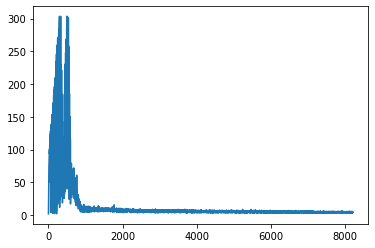

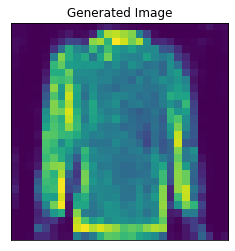

Iteration [8201/10000]......0.119(s) gen: -184.10670 - disc_fake: 185.48531 - disc_real: 190.94967 - disc_real: 5.46436
Iteration [8202/10000]......0.119(s) gen: -185.27744 - disc_fake: 185.91230 - disc_real: 190.68831 - disc_real: 4.77601
Iteration [8203/10000]......0.114(s) gen: -186.52194 - disc_fake: 184.93496 - disc_real: 190.04382 - disc_real: 5.10886
Iteration [8204/10000]......0.116(s) gen: -184.48730 - disc_fake: 185.50281 - disc_real: 190.02808 - disc_real: 4.52527
Iteration [8205/10000]......0.115(s) gen: -186.02814 - disc_fake: 183.93699 - disc_real: 188.92485 - disc_real: 4.98785
Iteration [8206/10000]......0.115(s) gen: -185.47649 - disc_fake: 186.53195 - disc_real: 190.36779 - disc_real: 3.83585
Iteration [8207/10000]......0.115(s) gen: -185.46014 - disc_fake: 185.64024 - disc_real: 190.02852 - disc_real: 4.38828
Iteration [8208/10000]......0.116(s) gen: -187.30022 - disc_fake: 186.42850 - disc_real: 190.94187 - disc_real: 4.51337
Iteration [8209/10000]......0.116(s) gen

Iteration [8270/10000]......0.119(s) gen: -186.31848 - disc_fake: 184.74391 - disc_real: 190.53365 - disc_real: 5.78974
Iteration [8271/10000]......0.120(s) gen: -186.96646 - disc_fake: 187.78471 - disc_real: 191.81437 - disc_real: 4.02967
Iteration [8272/10000]......0.121(s) gen: -185.01141 - disc_fake: 185.45858 - disc_real: 190.89222 - disc_real: 5.43364
Iteration [8273/10000]......0.120(s) gen: -187.55952 - disc_fake: 187.19329 - disc_real: 190.91583 - disc_real: 3.72254
Iteration [8274/10000]......0.122(s) gen: -184.96838 - disc_fake: 186.29575 - disc_real: 190.69110 - disc_real: 4.39535
Iteration [8275/10000]......0.120(s) gen: -185.41521 - disc_fake: 185.28862 - disc_real: 189.69188 - disc_real: 4.40326
Iteration [8276/10000]......0.120(s) gen: -184.81366 - disc_fake: 185.93826 - disc_real: 190.21646 - disc_real: 4.27820
Iteration [8277/10000]......0.119(s) gen: -186.75194 - disc_fake: 186.01682 - disc_real: 190.63299 - disc_real: 4.61617
Iteration [8278/10000]......0.119(s) gen

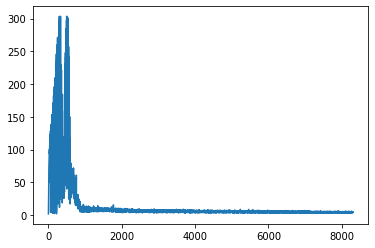

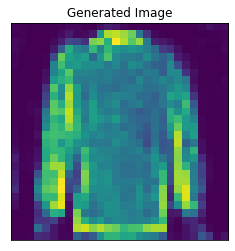

Iteration [8301/10000]......0.122(s) gen: -186.54933 - disc_fake: 188.86875 - disc_real: 192.26198 - disc_real: 3.39323
Iteration [8302/10000]......0.122(s) gen: -185.80167 - disc_fake: 186.13267 - disc_real: 190.71437 - disc_real: 4.58170
Iteration [8303/10000]......0.118(s) gen: -185.31464 - disc_fake: 185.35320 - disc_real: 190.29583 - disc_real: 4.94263
Iteration [8304/10000]......0.118(s) gen: -186.99664 - disc_fake: 185.90712 - disc_real: 190.56851 - disc_real: 4.66139
Iteration [8305/10000]......0.118(s) gen: -184.02444 - disc_fake: 186.61385 - disc_real: 190.11880 - disc_real: 3.50495
Iteration [8306/10000]......0.118(s) gen: -184.69110 - disc_fake: 184.61782 - disc_real: 188.84663 - disc_real: 4.22881
Iteration [8307/10000]......0.119(s) gen: -183.99077 - disc_fake: 184.27019 - disc_real: 189.02332 - disc_real: 4.75313
Iteration [8308/10000]......0.119(s) gen: -184.72675 - disc_fake: 184.62957 - disc_real: 189.21308 - disc_real: 4.58351
Iteration [8309/10000]......0.120(s) gen

Iteration [8370/10000]......0.119(s) gen: -186.58910 - disc_fake: 186.63834 - disc_real: 191.21320 - disc_real: 4.57487
Iteration [8371/10000]......0.119(s) gen: -185.42946 - disc_fake: 186.47359 - disc_real: 190.97051 - disc_real: 4.49693
Iteration [8372/10000]......0.119(s) gen: -186.21442 - disc_fake: 186.14153 - disc_real: 190.53253 - disc_real: 4.39100
Iteration [8373/10000]......0.120(s) gen: -186.91589 - disc_fake: 185.78526 - disc_real: 190.06945 - disc_real: 4.28419
Iteration [8374/10000]......0.119(s) gen: -184.65318 - disc_fake: 186.13274 - disc_real: 191.07651 - disc_real: 4.94377
Iteration [8375/10000]......0.119(s) gen: -187.01447 - disc_fake: 186.31507 - disc_real: 191.35748 - disc_real: 5.04242
Iteration [8376/10000]......0.119(s) gen: -187.19412 - disc_fake: 186.71194 - disc_real: 191.00518 - disc_real: 4.29324
Iteration [8377/10000]......0.119(s) gen: -188.73392 - disc_fake: 186.56695 - disc_real: 191.81588 - disc_real: 5.24894
Iteration [8378/10000]......0.118(s) gen

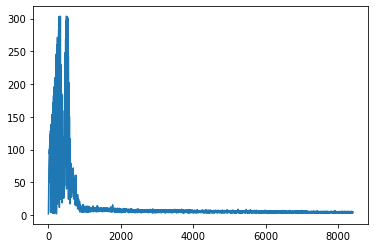

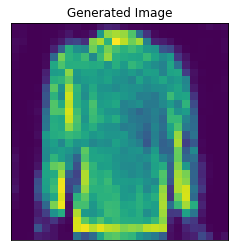

Iteration [8401/10000]......0.122(s) gen: -185.89923 - disc_fake: 187.02568 - disc_real: 190.73199 - disc_real: 3.70631
Iteration [8402/10000]......0.119(s) gen: -186.54941 - disc_fake: 184.72583 - disc_real: 190.02392 - disc_real: 5.29809
Iteration [8403/10000]......0.117(s) gen: -187.73010 - disc_fake: 187.03552 - disc_real: 191.84418 - disc_real: 4.80866
Iteration [8404/10000]......0.118(s) gen: -186.08792 - disc_fake: 186.72821 - disc_real: 190.74227 - disc_real: 4.01406
Iteration [8405/10000]......0.117(s) gen: -185.90132 - disc_fake: 185.74625 - disc_real: 190.08143 - disc_real: 4.33518
Iteration [8406/10000]......0.116(s) gen: -187.17380 - disc_fake: 186.27063 - disc_real: 191.47664 - disc_real: 5.20600
Iteration [8407/10000]......0.118(s) gen: -188.54298 - disc_fake: 185.90648 - disc_real: 191.68688 - disc_real: 5.78039
Iteration [8408/10000]......0.117(s) gen: -187.91077 - disc_fake: 186.97393 - disc_real: 191.94710 - disc_real: 4.97317
Iteration [8409/10000]......0.117(s) gen

Iteration [8470/10000]......0.117(s) gen: -187.60602 - disc_fake: 185.87188 - disc_real: 190.46653 - disc_real: 4.59464
Iteration [8471/10000]......0.117(s) gen: -187.71735 - disc_fake: 187.92740 - disc_real: 191.48922 - disc_real: 3.56182
Iteration [8472/10000]......0.118(s) gen: -184.71579 - disc_fake: 186.42552 - disc_real: 190.31734 - disc_real: 3.89182
Iteration [8473/10000]......0.120(s) gen: -185.87924 - disc_fake: 184.99482 - disc_real: 189.08612 - disc_real: 4.09131
Iteration [8474/10000]......0.119(s) gen: -186.17197 - disc_fake: 185.39324 - disc_real: 189.79304 - disc_real: 4.39980
Iteration [8475/10000]......0.119(s) gen: -186.04816 - disc_fake: 185.65771 - disc_real: 190.21173 - disc_real: 4.55403
Iteration [8476/10000]......0.121(s) gen: -187.17044 - disc_fake: 185.50797 - disc_real: 190.42433 - disc_real: 4.91636
Iteration [8477/10000]......0.122(s) gen: -185.62985 - disc_fake: 186.32003 - disc_real: 190.46238 - disc_real: 4.14234
Iteration [8478/10000]......0.122(s) gen

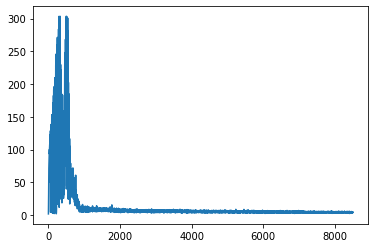

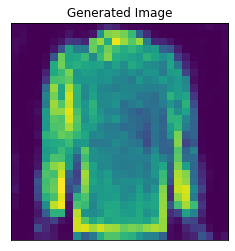

Iteration [8501/10000]......0.117(s) gen: -187.58987 - disc_fake: 186.78318 - disc_real: 191.52699 - disc_real: 4.74382
Iteration [8502/10000]......0.116(s) gen: -186.90250 - disc_fake: 186.46572 - disc_real: 191.02061 - disc_real: 4.55489
Iteration [8503/10000]......0.115(s) gen: -184.67165 - disc_fake: 186.07082 - disc_real: 190.76603 - disc_real: 4.69522
Iteration [8504/10000]......0.115(s) gen: -187.82822 - disc_fake: 187.60904 - disc_real: 191.08626 - disc_real: 3.47722
Iteration [8505/10000]......0.116(s) gen: -185.09773 - disc_fake: 186.88232 - disc_real: 190.65090 - disc_real: 3.76858
Iteration [8506/10000]......0.116(s) gen: -186.85240 - disc_fake: 186.32251 - disc_real: 190.48837 - disc_real: 4.16586
Iteration [8507/10000]......0.117(s) gen: -185.20209 - disc_fake: 186.17355 - disc_real: 190.55040 - disc_real: 4.37685
Iteration [8508/10000]......0.118(s) gen: -187.21469 - disc_fake: 187.06856 - disc_real: 191.36486 - disc_real: 4.29630
Iteration [8509/10000]......0.118(s) gen

Iteration [8570/10000]......0.122(s) gen: -186.77603 - disc_fake: 188.93625 - disc_real: 192.21317 - disc_real: 3.27692
Iteration [8571/10000]......0.122(s) gen: -186.14801 - disc_fake: 186.26610 - disc_real: 190.50607 - disc_real: 4.23997
Iteration [8572/10000]......0.122(s) gen: -186.71829 - disc_fake: 186.07774 - disc_real: 190.94125 - disc_real: 4.86351
Iteration [8573/10000]......0.122(s) gen: -185.29089 - disc_fake: 186.39279 - disc_real: 190.99311 - disc_real: 4.60032
Iteration [8574/10000]......0.122(s) gen: -188.21136 - disc_fake: 185.50143 - disc_real: 190.63489 - disc_real: 5.13346
Iteration [8575/10000]......0.120(s) gen: -187.75294 - disc_fake: 188.28929 - disc_real: 191.00171 - disc_real: 2.71242
Iteration [8576/10000]......0.120(s) gen: -185.08040 - disc_fake: 187.20100 - disc_real: 190.78558 - disc_real: 3.58458
Iteration [8577/10000]......0.118(s) gen: -184.31537 - disc_fake: 184.62668 - disc_real: 188.66049 - disc_real: 4.03381
Iteration [8578/10000]......0.118(s) gen

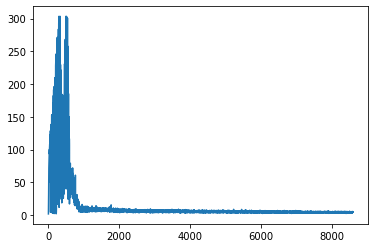

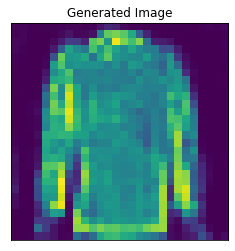

Iteration [8601/10000]......0.124(s) gen: -187.61282 - disc_fake: 186.96108 - disc_real: 190.13133 - disc_real: 3.17025
Iteration [8602/10000]......0.120(s) gen: -189.18741 - disc_fake: 188.65626 - disc_real: 191.88907 - disc_real: 3.23282
Iteration [8603/10000]......0.119(s) gen: -187.30405 - disc_fake: 188.68806 - disc_real: 192.13618 - disc_real: 3.44811
Iteration [8604/10000]......0.115(s) gen: -186.87062 - disc_fake: 187.44191 - disc_real: 190.96056 - disc_real: 3.51865
Iteration [8605/10000]......0.118(s) gen: -184.71687 - disc_fake: 185.91274 - disc_real: 189.99856 - disc_real: 4.08582
Iteration [8606/10000]......0.116(s) gen: -184.69003 - disc_fake: 184.47357 - disc_real: 188.80776 - disc_real: 4.33419
Iteration [8607/10000]......0.116(s) gen: -183.94557 - disc_fake: 184.56974 - disc_real: 189.28433 - disc_real: 4.71460
Iteration [8608/10000]......0.119(s) gen: -184.39720 - disc_fake: 184.56279 - disc_real: 189.34361 - disc_real: 4.78082
Iteration [8609/10000]......0.118(s) gen

Iteration [8670/10000]......0.126(s) gen: -185.45325 - disc_fake: 185.79455 - disc_real: 190.34386 - disc_real: 4.54931
Iteration [8671/10000]......0.125(s) gen: -185.54309 - disc_fake: 186.40121 - disc_real: 190.93776 - disc_real: 4.53654
Iteration [8672/10000]......0.124(s) gen: -185.06561 - disc_fake: 186.26709 - disc_real: 190.83178 - disc_real: 4.56469
Iteration [8673/10000]......0.125(s) gen: -186.41129 - disc_fake: 186.24762 - disc_real: 190.96676 - disc_real: 4.71914
Iteration [8674/10000]......0.122(s) gen: -187.53534 - disc_fake: 186.97636 - disc_real: 191.19905 - disc_real: 4.22269
Iteration [8675/10000]......0.120(s) gen: -185.83679 - disc_fake: 186.65752 - disc_real: 191.01558 - disc_real: 4.35806
Iteration [8676/10000]......0.120(s) gen: -186.50122 - disc_fake: 185.99652 - disc_real: 190.54657 - disc_real: 4.55005
Iteration [8677/10000]......0.119(s) gen: -183.94180 - disc_fake: 185.95525 - disc_real: 189.97495 - disc_real: 4.01970
Iteration [8678/10000]......0.120(s) gen

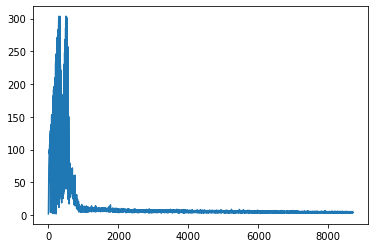

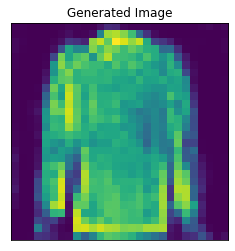

Iteration [8701/10000]......0.122(s) gen: -186.24838 - disc_fake: 187.27348 - disc_real: 191.16819 - disc_real: 3.89471
Iteration [8702/10000]......0.120(s) gen: -187.12775 - disc_fake: 184.81650 - disc_real: 190.02787 - disc_real: 5.21136
Iteration [8703/10000]......0.117(s) gen: -184.21539 - disc_fake: 186.60814 - disc_real: 190.55169 - disc_real: 3.94355
Iteration [8704/10000]......0.118(s) gen: -184.71613 - disc_fake: 184.38500 - disc_real: 189.14405 - disc_real: 4.75905
Iteration [8705/10000]......0.119(s) gen: -185.25333 - disc_fake: 185.27458 - disc_real: 189.37652 - disc_real: 4.10193
Iteration [8706/10000]......0.118(s) gen: -186.43123 - disc_fake: 185.40981 - disc_real: 189.49344 - disc_real: 4.08364
Iteration [8707/10000]......0.122(s) gen: -185.67339 - disc_fake: 185.30732 - disc_real: 189.49185 - disc_real: 4.18454
Iteration [8708/10000]......0.119(s) gen: -185.96965 - disc_fake: 185.90038 - disc_real: 190.46715 - disc_real: 4.56677
Iteration [8709/10000]......0.120(s) gen

Iteration [8770/10000]......0.124(s) gen: -185.26474 - disc_fake: 186.35849 - disc_real: 190.56706 - disc_real: 4.20857
Iteration [8771/10000]......0.123(s) gen: -186.63956 - disc_fake: 184.55565 - disc_real: 189.61437 - disc_real: 5.05872
Iteration [8772/10000]......0.123(s) gen: -185.80252 - disc_fake: 186.81847 - disc_real: 190.12341 - disc_real: 3.30493
Iteration [8773/10000]......0.121(s) gen: -186.68788 - disc_fake: 186.38947 - disc_real: 191.04932 - disc_real: 4.65985
Iteration [8774/10000]......0.124(s) gen: -187.82722 - disc_fake: 186.36628 - disc_real: 191.07595 - disc_real: 4.70967
Iteration [8775/10000]......0.121(s) gen: -186.64807 - disc_fake: 186.76649 - disc_real: 191.06570 - disc_real: 4.29921
Iteration [8776/10000]......0.122(s) gen: -185.64401 - disc_fake: 186.08198 - disc_real: 190.40808 - disc_real: 4.32610
Iteration [8777/10000]......0.121(s) gen: -187.27742 - disc_fake: 186.37350 - disc_real: 190.55052 - disc_real: 4.17702
Iteration [8778/10000]......0.122(s) gen

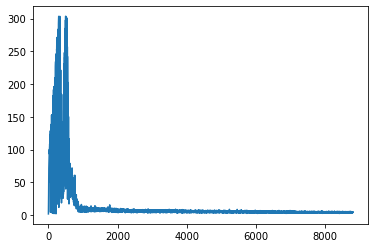

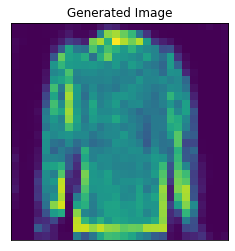

Iteration [8801/10000]......0.121(s) gen: -188.44894 - disc_fake: 186.43012 - disc_real: 191.30674 - disc_real: 4.87662
Iteration [8802/10000]......0.120(s) gen: -185.77945 - disc_fake: 187.17050 - disc_real: 191.46243 - disc_real: 4.29194
Iteration [8803/10000]......0.117(s) gen: -187.67761 - disc_fake: 186.68882 - disc_real: 190.81614 - disc_real: 4.12732
Iteration [8804/10000]......0.114(s) gen: -185.66116 - disc_fake: 187.35180 - disc_real: 190.81823 - disc_real: 3.46643
Iteration [8805/10000]......0.116(s) gen: -185.08310 - disc_fake: 185.37709 - disc_real: 189.66828 - disc_real: 4.29119
Iteration [8806/10000]......0.115(s) gen: -186.35730 - disc_fake: 184.27846 - disc_real: 189.01090 - disc_real: 4.73244
Iteration [8807/10000]......0.116(s) gen: -186.34709 - disc_fake: 186.65056 - disc_real: 190.39403 - disc_real: 3.74347
Iteration [8808/10000]......0.114(s) gen: -185.13872 - disc_fake: 185.82615 - disc_real: 189.95108 - disc_real: 4.12493
Iteration [8809/10000]......0.116(s) gen

Iteration [8870/10000]......0.123(s) gen: -185.51041 - disc_fake: 185.42206 - disc_real: 189.70760 - disc_real: 4.28554
Iteration [8871/10000]......0.124(s) gen: -184.26721 - disc_fake: 185.15136 - disc_real: 189.89798 - disc_real: 4.74662
Iteration [8872/10000]......0.125(s) gen: -188.05324 - disc_fake: 186.79803 - disc_real: 190.64284 - disc_real: 3.84482
Iteration [8873/10000]......0.127(s) gen: -188.26611 - disc_fake: 188.60685 - disc_real: 192.08278 - disc_real: 3.47593
Iteration [8874/10000]......0.125(s) gen: -186.34103 - disc_fake: 187.87141 - disc_real: 191.95511 - disc_real: 4.08370
Iteration [8875/10000]......0.123(s) gen: -185.71336 - disc_fake: 186.33615 - disc_real: 190.46768 - disc_real: 4.13153
Iteration [8876/10000]......0.123(s) gen: -186.79373 - disc_fake: 186.04913 - disc_real: 190.42967 - disc_real: 4.38055
Iteration [8877/10000]......0.126(s) gen: -185.71149 - disc_fake: 185.09754 - disc_real: 190.28728 - disc_real: 5.18974
Iteration [8878/10000]......0.123(s) gen

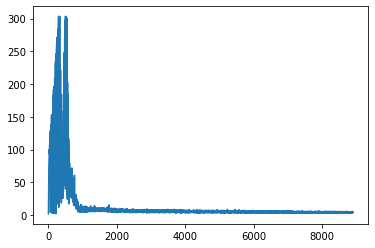

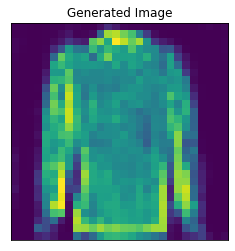

Iteration [8901/10000]......0.117(s) gen: -187.74957 - disc_fake: 189.30229 - disc_real: 192.59556 - disc_real: 3.29327
Iteration [8902/10000]......0.119(s) gen: -187.47620 - disc_fake: 186.58419 - disc_real: 190.73250 - disc_real: 4.14831
Iteration [8903/10000]......0.115(s) gen: -183.83691 - disc_fake: 186.35737 - disc_real: 190.57868 - disc_real: 4.22131
Iteration [8904/10000]......0.115(s) gen: -184.98123 - disc_fake: 185.47235 - disc_real: 190.15109 - disc_real: 4.67874
Iteration [8905/10000]......0.116(s) gen: -186.59906 - disc_fake: 186.02845 - disc_real: 190.23961 - disc_real: 4.21116
Iteration [8906/10000]......0.115(s) gen: -187.64531 - disc_fake: 186.84914 - disc_real: 191.20266 - disc_real: 4.35352
Iteration [8907/10000]......0.115(s) gen: -187.03714 - disc_fake: 187.96308 - disc_real: 192.14396 - disc_real: 4.18088
Iteration [8908/10000]......0.118(s) gen: -187.39120 - disc_fake: 187.34152 - disc_real: 191.99118 - disc_real: 4.64966
Iteration [8909/10000]......0.116(s) gen

Iteration [8970/10000]......0.122(s) gen: -188.79863 - disc_fake: 188.52132 - disc_real: 192.29408 - disc_real: 3.77275
Iteration [8971/10000]......0.118(s) gen: -184.21797 - disc_fake: 186.79668 - disc_real: 190.94712 - disc_real: 4.15044
Iteration [8972/10000]......0.118(s) gen: -185.61638 - disc_fake: 186.32455 - disc_real: 190.62476 - disc_real: 4.30021
Iteration [8973/10000]......0.122(s) gen: -186.25803 - disc_fake: 186.52395 - disc_real: 190.84985 - disc_real: 4.32590
Iteration [8974/10000]......0.120(s) gen: -185.07886 - disc_fake: 186.41002 - disc_real: 191.15568 - disc_real: 4.74565
Iteration [8975/10000]......0.119(s) gen: -188.55823 - disc_fake: 186.88456 - disc_real: 191.11905 - disc_real: 4.23449
Iteration [8976/10000]......0.124(s) gen: -188.27608 - disc_fake: 188.75471 - disc_real: 192.75309 - disc_real: 3.99837
Iteration [8977/10000]......0.123(s) gen: -186.98947 - disc_fake: 187.83078 - disc_real: 191.35081 - disc_real: 3.52003
Iteration [8978/10000]......0.123(s) gen

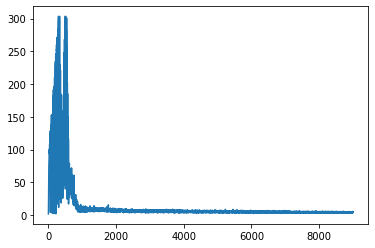

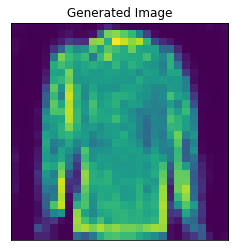

Iteration [9001/10000]......0.115(s) gen: -187.43100 - disc_fake: 186.65170 - disc_real: 190.16168 - disc_real: 3.50998
Iteration [9002/10000]......0.126(s) gen: -187.27658 - disc_fake: 188.13739 - disc_real: 191.70139 - disc_real: 3.56400
Iteration [9003/10000]......0.135(s) gen: -186.04727 - disc_fake: 187.49251 - disc_real: 191.30036 - disc_real: 3.80784
Iteration [9004/10000]......0.136(s) gen: -186.62692 - disc_fake: 186.56642 - disc_real: 190.52665 - disc_real: 3.96023
Iteration [9005/10000]......0.134(s) gen: -188.13257 - disc_fake: 186.21030 - disc_real: 190.49189 - disc_real: 4.28159
Iteration [9006/10000]......0.134(s) gen: -186.39716 - disc_fake: 187.42885 - disc_real: 191.30127 - disc_real: 3.87242
Iteration [9007/10000]......0.134(s) gen: -187.00391 - disc_fake: 186.75291 - disc_real: 191.29686 - disc_real: 4.54395
Iteration [9008/10000]......0.135(s) gen: -187.77063 - disc_fake: 186.30425 - disc_real: 190.33972 - disc_real: 4.03548
Iteration [9009/10000]......0.136(s) gen

Iteration [9070/10000]......0.122(s) gen: -188.96970 - disc_fake: 189.97289 - disc_real: 192.79972 - disc_real: 2.82683
Iteration [9071/10000]......0.117(s) gen: -188.53513 - disc_fake: 188.83844 - disc_real: 192.08076 - disc_real: 3.24232
Iteration [9072/10000]......0.120(s) gen: -185.74483 - disc_fake: 187.22500 - disc_real: 191.17942 - disc_real: 3.95442
Iteration [9073/10000]......0.119(s) gen: -186.03452 - disc_fake: 185.68600 - disc_real: 189.76167 - disc_real: 4.07567
Iteration [9074/10000]......0.122(s) gen: -186.20578 - disc_fake: 186.16638 - disc_real: 190.11063 - disc_real: 3.94424
Iteration [9075/10000]......0.122(s) gen: -186.46472 - disc_fake: 186.27337 - disc_real: 190.24589 - disc_real: 3.97252
Iteration [9076/10000]......0.122(s) gen: -186.26009 - disc_fake: 186.91742 - disc_real: 190.59629 - disc_real: 3.67887
Iteration [9077/10000]......0.119(s) gen: -188.03113 - disc_fake: 187.19557 - disc_real: 191.52588 - disc_real: 4.33032
Iteration [9078/10000]......0.120(s) gen

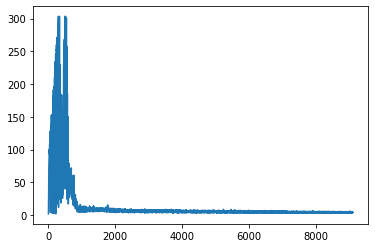

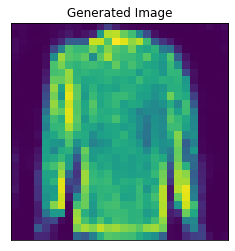

Iteration [9101/10000]......0.124(s) gen: -186.22472 - disc_fake: 187.74367 - disc_real: 191.59937 - disc_real: 3.85570
Iteration [9102/10000]......0.120(s) gen: -187.26135 - disc_fake: 185.29149 - disc_real: 190.27902 - disc_real: 4.98753
Iteration [9103/10000]......0.117(s) gen: -186.42627 - disc_fake: 186.08271 - disc_real: 190.92212 - disc_real: 4.83941
Iteration [9104/10000]......0.120(s) gen: -187.72545 - disc_fake: 186.96126 - disc_real: 190.97877 - disc_real: 4.01750
Iteration [9105/10000]......0.120(s) gen: -187.65622 - disc_fake: 187.36427 - disc_real: 191.70898 - disc_real: 4.34471
Iteration [9106/10000]......0.123(s) gen: -188.57161 - disc_fake: 187.98496 - disc_real: 192.03947 - disc_real: 4.05452
Iteration [9107/10000]......0.121(s) gen: -186.70801 - disc_fake: 187.68579 - disc_real: 191.19456 - disc_real: 3.50878
Iteration [9108/10000]......0.122(s) gen: -185.93613 - disc_fake: 186.83182 - disc_real: 191.54556 - disc_real: 4.71374
Iteration [9109/10000]......0.122(s) gen

Iteration [9170/10000]......0.118(s) gen: -186.89883 - disc_fake: 187.93555 - disc_real: 191.99607 - disc_real: 4.06052
Iteration [9171/10000]......0.119(s) gen: -187.19092 - disc_fake: 186.65985 - disc_real: 191.62514 - disc_real: 4.96529
Iteration [9172/10000]......0.119(s) gen: -187.18927 - disc_fake: 187.95198 - disc_real: 192.51093 - disc_real: 4.55895
Iteration [9173/10000]......0.120(s) gen: -186.51495 - disc_fake: 187.52286 - disc_real: 192.24641 - disc_real: 4.72354
Iteration [9174/10000]......0.119(s) gen: -188.29697 - disc_fake: 188.61334 - disc_real: 192.87970 - disc_real: 4.26636
Iteration [9175/10000]......0.120(s) gen: -189.07872 - disc_fake: 188.28170 - disc_real: 192.92976 - disc_real: 4.64807
Iteration [9176/10000]......0.122(s) gen: -186.56079 - disc_fake: 189.00352 - disc_real: 192.49498 - disc_real: 3.49146
Iteration [9177/10000]......0.122(s) gen: -184.02876 - disc_fake: 186.46780 - disc_real: 190.43108 - disc_real: 3.96328
Iteration [9178/10000]......0.123(s) gen

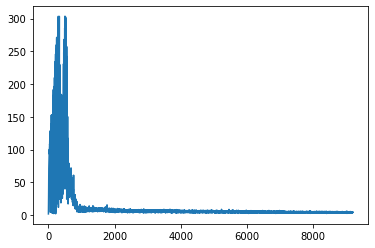

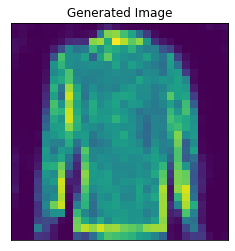

Iteration [9201/10000]......0.122(s) gen: -186.64693 - disc_fake: 187.35028 - disc_real: 191.78156 - disc_real: 4.43127
Iteration [9202/10000]......0.117(s) gen: -188.63684 - disc_fake: 188.23609 - disc_real: 192.42001 - disc_real: 4.18392
Iteration [9203/10000]......0.116(s) gen: -186.26648 - disc_fake: 187.59887 - disc_real: 192.17061 - disc_real: 4.57173
Iteration [9204/10000]......0.117(s) gen: -189.16878 - disc_fake: 188.12654 - disc_real: 192.49450 - disc_real: 4.36796
Iteration [9205/10000]......0.117(s) gen: -185.52907 - disc_fake: 187.99264 - disc_real: 191.68110 - disc_real: 3.68846
Iteration [9206/10000]......0.115(s) gen: -187.34174 - disc_fake: 185.72594 - disc_real: 190.24505 - disc_real: 4.51911
Iteration [9207/10000]......0.116(s) gen: -187.18202 - disc_fake: 186.48104 - disc_real: 190.44285 - disc_real: 3.96181
Iteration [9208/10000]......0.118(s) gen: -185.95477 - disc_fake: 186.80990 - disc_real: 191.30761 - disc_real: 4.49772
Iteration [9209/10000]......0.118(s) gen

Iteration [9270/10000]......0.119(s) gen: -186.85927 - disc_fake: 187.60570 - disc_real: 192.50514 - disc_real: 4.89944
Iteration [9271/10000]......0.121(s) gen: -187.94916 - disc_fake: 188.10056 - disc_real: 191.94909 - disc_real: 3.84853
Iteration [9272/10000]......0.121(s) gen: -187.80087 - disc_fake: 188.31687 - disc_real: 191.69476 - disc_real: 3.37789
Iteration [9273/10000]......0.120(s) gen: -188.57434 - disc_fake: 188.00127 - disc_real: 191.70466 - disc_real: 3.70339
Iteration [9274/10000]......0.118(s) gen: -187.90059 - disc_fake: 188.35464 - disc_real: 192.20190 - disc_real: 3.84726
Iteration [9275/10000]......0.119(s) gen: -188.25217 - disc_fake: 187.83408 - disc_real: 192.12153 - disc_real: 4.28745
Iteration [9276/10000]......0.119(s) gen: -189.37680 - disc_fake: 188.01064 - disc_real: 192.35278 - disc_real: 4.34214
Iteration [9277/10000]......0.120(s) gen: -185.07042 - disc_fake: 188.32129 - disc_real: 192.70469 - disc_real: 4.38340
Iteration [9278/10000]......0.119(s) gen

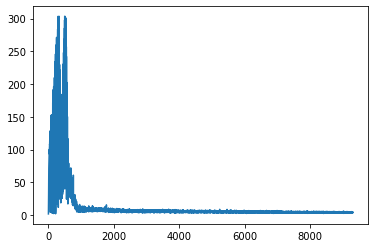

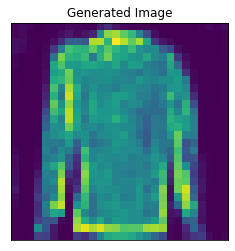

Iteration [9301/10000]......0.120(s) gen: -187.65656 - disc_fake: 187.06828 - disc_real: 190.94340 - disc_real: 3.87512
Iteration [9302/10000]......0.119(s) gen: -187.39243 - disc_fake: 187.37522 - disc_real: 191.42939 - disc_real: 4.05417
Iteration [9303/10000]......0.116(s) gen: -186.96744 - disc_fake: 187.75072 - disc_real: 192.29742 - disc_real: 4.54670
Iteration [9304/10000]......0.118(s) gen: -189.06204 - disc_fake: 189.09939 - disc_real: 192.89367 - disc_real: 3.79428
Iteration [9305/10000]......0.117(s) gen: -189.16679 - disc_fake: 187.94867 - disc_real: 192.06936 - disc_real: 4.12069
Iteration [9306/10000]......0.119(s) gen: -188.44066 - disc_fake: 187.39597 - disc_real: 192.41790 - disc_real: 5.02193
Iteration [9307/10000]......0.117(s) gen: -188.31129 - disc_fake: 187.92254 - disc_real: 192.24419 - disc_real: 4.32165
Iteration [9308/10000]......0.119(s) gen: -188.60555 - disc_fake: 187.72278 - disc_real: 192.01018 - disc_real: 4.28741
Iteration [9309/10000]......0.119(s) gen

Iteration [9370/10000]......0.119(s) gen: -190.51404 - disc_fake: 188.24761 - disc_real: 192.72776 - disc_real: 4.48015
Iteration [9371/10000]......0.118(s) gen: -188.07883 - disc_fake: 190.51971 - disc_real: 193.99206 - disc_real: 3.47235
Iteration [9372/10000]......0.120(s) gen: -188.15858 - disc_fake: 187.32014 - disc_real: 192.28101 - disc_real: 4.96086
Iteration [9373/10000]......0.119(s) gen: -188.04308 - disc_fake: 187.54425 - disc_real: 192.14023 - disc_real: 4.59597
Iteration [9374/10000]......0.118(s) gen: -189.50766 - disc_fake: 187.89586 - disc_real: 192.04975 - disc_real: 4.15389
Iteration [9375/10000]......0.121(s) gen: -189.15286 - disc_fake: 188.43978 - disc_real: 192.81565 - disc_real: 4.37587
Iteration [9376/10000]......0.122(s) gen: -187.50233 - disc_fake: 187.41968 - disc_real: 191.67151 - disc_real: 4.25183
Iteration [9377/10000]......0.121(s) gen: -189.80734 - disc_fake: 187.55186 - disc_real: 192.43400 - disc_real: 4.88215
Iteration [9378/10000]......0.122(s) gen

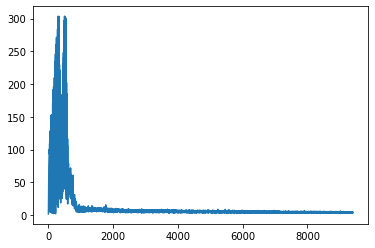

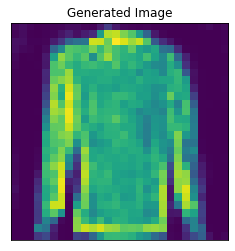

Iteration [9401/10000]......0.118(s) gen: -187.99345 - disc_fake: 186.88181 - disc_real: 190.94905 - disc_real: 4.06723
Iteration [9402/10000]......0.115(s) gen: -187.22601 - disc_fake: 187.79953 - disc_real: 191.39810 - disc_real: 3.59857
Iteration [9403/10000]......0.115(s) gen: -187.01453 - disc_fake: 186.77975 - disc_real: 191.07309 - disc_real: 4.29333
Iteration [9404/10000]......0.116(s) gen: -187.42819 - disc_fake: 186.89502 - disc_real: 191.43701 - disc_real: 4.54199
Iteration [9405/10000]......0.116(s) gen: -186.92810 - disc_fake: 186.75924 - disc_real: 191.26953 - disc_real: 4.51028
Iteration [9406/10000]......0.118(s) gen: -188.62234 - disc_fake: 189.31012 - disc_real: 193.10190 - disc_real: 3.79178
Iteration [9407/10000]......0.117(s) gen: -190.17703 - disc_fake: 189.17392 - disc_real: 192.63973 - disc_real: 3.46581
Iteration [9408/10000]......0.117(s) gen: -189.38715 - disc_fake: 189.97165 - disc_real: 192.64973 - disc_real: 2.67808
Iteration [9409/10000]......0.119(s) gen

Iteration [9470/10000]......0.121(s) gen: -186.33279 - disc_fake: 187.94843 - disc_real: 191.65983 - disc_real: 3.71140
Iteration [9471/10000]......0.125(s) gen: -189.66586 - disc_fake: 186.77950 - disc_real: 191.83195 - disc_real: 5.05244
Iteration [9472/10000]......0.124(s) gen: -188.27321 - disc_fake: 188.66335 - disc_real: 192.54411 - disc_real: 3.88076
Iteration [9473/10000]......0.121(s) gen: -185.94669 - disc_fake: 187.90685 - disc_real: 192.63776 - disc_real: 4.73091
Iteration [9474/10000]......0.124(s) gen: -190.49475 - disc_fake: 189.41437 - disc_real: 193.01213 - disc_real: 3.59775
Iteration [9475/10000]......0.123(s) gen: -189.49072 - disc_fake: 190.78286 - disc_real: 194.04921 - disc_real: 3.26635
Iteration [9476/10000]......0.119(s) gen: -186.96017 - disc_fake: 188.69573 - disc_real: 191.78883 - disc_real: 3.09310
Iteration [9477/10000]......0.119(s) gen: -185.92355 - disc_fake: 185.81607 - disc_real: 190.64605 - disc_real: 4.82999
Iteration [9478/10000]......0.118(s) gen

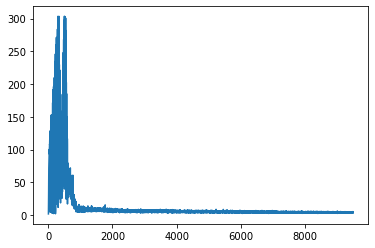

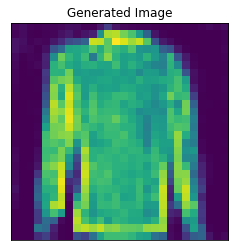

Iteration [9501/10000]......0.120(s) gen: -187.00363 - disc_fake: 188.33067 - disc_real: 192.81621 - disc_real: 4.48554
Iteration [9502/10000]......0.118(s) gen: -188.51138 - disc_fake: 187.27127 - disc_real: 191.48226 - disc_real: 4.21099
Iteration [9503/10000]......0.117(s) gen: -188.26585 - disc_fake: 188.41187 - disc_real: 191.26913 - disc_real: 2.85725
Iteration [9504/10000]......0.118(s) gen: -187.17851 - disc_fake: 187.90026 - disc_real: 191.44745 - disc_real: 3.54720
Iteration [9505/10000]......0.118(s) gen: -187.23315 - disc_fake: 187.57416 - disc_real: 191.24460 - disc_real: 3.67044
Iteration [9506/10000]......0.119(s) gen: -187.10330 - disc_fake: 187.06574 - disc_real: 191.36811 - disc_real: 4.30237
Iteration [9507/10000]......0.117(s) gen: -186.20825 - disc_fake: 188.03820 - disc_real: 191.92348 - disc_real: 3.88528
Iteration [9508/10000]......0.119(s) gen: -185.77988 - disc_fake: 186.90664 - disc_real: 191.00893 - disc_real: 4.10229
Iteration [9509/10000]......0.119(s) gen

Iteration [9570/10000]......0.124(s) gen: -187.78754 - disc_fake: 187.66460 - disc_real: 191.51055 - disc_real: 3.84595
Iteration [9571/10000]......0.122(s) gen: -185.23541 - disc_fake: 186.35873 - disc_real: 190.56665 - disc_real: 4.20792
Iteration [9572/10000]......0.123(s) gen: -185.70801 - disc_fake: 186.22758 - disc_real: 190.98931 - disc_real: 4.76172
Iteration [9573/10000]......0.125(s) gen: -188.57086 - disc_fake: 186.89224 - disc_real: 191.35192 - disc_real: 4.45968
Iteration [9574/10000]......0.125(s) gen: -187.58426 - disc_fake: 188.07285 - disc_real: 191.75146 - disc_real: 3.67860
Iteration [9575/10000]......0.120(s) gen: -186.30751 - disc_fake: 187.33831 - disc_real: 191.28260 - disc_real: 3.94429
Iteration [9576/10000]......0.123(s) gen: -187.82256 - disc_fake: 186.41940 - disc_real: 190.58908 - disc_real: 4.16969
Iteration [9577/10000]......0.123(s) gen: -187.33743 - disc_fake: 187.97528 - disc_real: 192.65665 - disc_real: 4.68137
Iteration [9578/10000]......0.120(s) gen

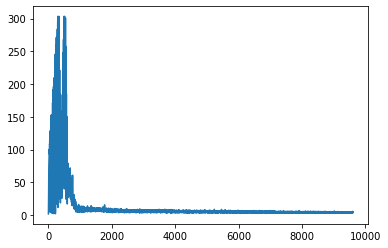

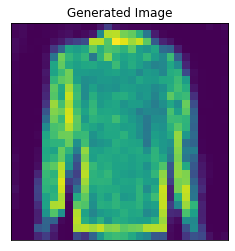

Iteration [9601/10000]......0.118(s) gen: -186.66266 - disc_fake: 187.34531 - disc_real: 191.63205 - disc_real: 4.28674
Iteration [9602/10000]......0.116(s) gen: -184.26018 - disc_fake: 185.68602 - disc_real: 190.52964 - disc_real: 4.84362
Iteration [9603/10000]......0.119(s) gen: -186.33589 - disc_fake: 186.12879 - disc_real: 190.01132 - disc_real: 3.88253
Iteration [9604/10000]......0.120(s) gen: -185.22878 - disc_fake: 186.38727 - disc_real: 190.51884 - disc_real: 4.13158
Iteration [9605/10000]......0.118(s) gen: -188.66177 - disc_fake: 185.69068 - disc_real: 189.97371 - disc_real: 4.28303
Iteration [9606/10000]......0.116(s) gen: -189.83099 - disc_fake: 189.39962 - disc_real: 192.70143 - disc_real: 3.30180
Iteration [9607/10000]......0.118(s) gen: -185.61742 - disc_fake: 188.81552 - disc_real: 192.42583 - disc_real: 3.61030
Iteration [9608/10000]......0.120(s) gen: -185.08252 - disc_fake: 187.20662 - disc_real: 191.69294 - disc_real: 4.48632
Iteration [9609/10000]......0.118(s) gen

Iteration [9670/10000]......0.121(s) gen: -188.14026 - disc_fake: 187.44677 - disc_real: 191.80166 - disc_real: 4.35489
Iteration [9671/10000]......0.122(s) gen: -187.45248 - disc_fake: 187.45509 - disc_real: 191.63095 - disc_real: 4.17586
Iteration [9672/10000]......0.119(s) gen: -186.85841 - disc_fake: 187.20063 - disc_real: 191.63328 - disc_real: 4.43265
Iteration [9673/10000]......0.118(s) gen: -187.05103 - disc_fake: 187.38015 - disc_real: 191.41801 - disc_real: 4.03786
Iteration [9674/10000]......0.122(s) gen: -187.44339 - disc_fake: 187.73174 - disc_real: 192.58404 - disc_real: 4.85230
Iteration [9675/10000]......0.120(s) gen: -189.62491 - disc_fake: 188.56068 - disc_real: 193.37036 - disc_real: 4.80968
Iteration [9676/10000]......0.124(s) gen: -188.21341 - disc_fake: 189.29929 - disc_real: 193.89433 - disc_real: 4.59503
Iteration [9677/10000]......0.122(s) gen: -188.52194 - disc_fake: 188.00000 - disc_real: 192.39333 - disc_real: 4.39333
Iteration [9678/10000]......0.124(s) gen

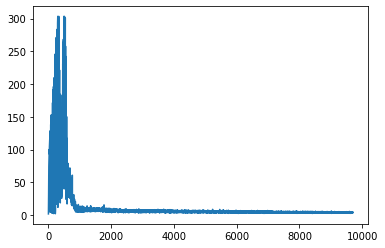

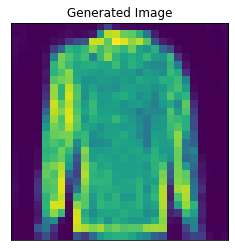

Iteration [9701/10000]......0.122(s) gen: -185.79895 - disc_fake: 188.20772 - disc_real: 191.58091 - disc_real: 3.37319
Iteration [9702/10000]......0.118(s) gen: -186.89435 - disc_fake: 185.63755 - disc_real: 190.73755 - disc_real: 5.10000
Iteration [9703/10000]......0.114(s) gen: -187.28143 - disc_fake: 187.55442 - disc_real: 192.00941 - disc_real: 4.45499
Iteration [9704/10000]......0.115(s) gen: -189.50366 - disc_fake: 188.48035 - disc_real: 192.57244 - disc_real: 4.09209
Iteration [9705/10000]......0.118(s) gen: -190.46356 - disc_fake: 189.90486 - disc_real: 193.03928 - disc_real: 3.13442
Iteration [9706/10000]......0.117(s) gen: -185.89621 - disc_fake: 188.64172 - disc_real: 192.42861 - disc_real: 3.78689
Iteration [9707/10000]......0.114(s) gen: -188.11508 - disc_fake: 185.74147 - disc_real: 190.45734 - disc_real: 4.71587
Iteration [9708/10000]......0.113(s) gen: -186.78502 - disc_fake: 186.88434 - disc_real: 191.28768 - disc_real: 4.40334
Iteration [9709/10000]......0.114(s) gen

Iteration [9770/10000]......0.122(s) gen: -186.10809 - disc_fake: 187.55430 - disc_real: 191.77613 - disc_real: 4.22183
Iteration [9771/10000]......0.126(s) gen: -188.88850 - disc_fake: 186.23299 - disc_real: 190.98275 - disc_real: 4.74976
Iteration [9772/10000]......0.125(s) gen: -187.34546 - disc_fake: 187.54774 - disc_real: 191.81169 - disc_real: 4.26396
Iteration [9773/10000]......0.121(s) gen: -188.18967 - disc_fake: 188.98869 - disc_real: 192.69042 - disc_real: 3.70174
Iteration [9774/10000]......0.124(s) gen: -183.70932 - disc_fake: 188.01249 - disc_real: 192.91810 - disc_real: 4.90561
Iteration [9775/10000]......0.123(s) gen: -189.44708 - disc_fake: 188.76530 - disc_real: 192.98260 - disc_real: 4.21730
Iteration [9776/10000]......0.122(s) gen: -188.22180 - disc_fake: 189.26899 - disc_real: 192.87509 - disc_real: 3.60609
Iteration [9777/10000]......0.124(s) gen: -187.02016 - disc_fake: 187.56311 - disc_real: 192.06494 - disc_real: 4.50182
Iteration [9778/10000]......0.122(s) gen

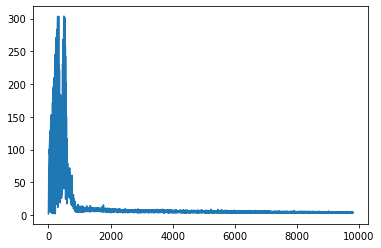

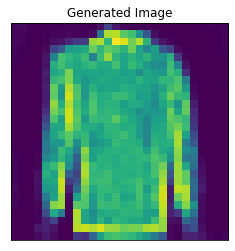

Iteration [9801/10000]......0.119(s) gen: -186.54408 - disc_fake: 187.27491 - disc_real: 191.41440 - disc_real: 4.13948
Iteration [9802/10000]......0.115(s) gen: -186.92538 - disc_fake: 186.73550 - disc_real: 190.39194 - disc_real: 3.65644
Iteration [9803/10000]......0.114(s) gen: -187.00516 - disc_fake: 186.90304 - disc_real: 191.13296 - disc_real: 4.22992
Iteration [9804/10000]......0.115(s) gen: -186.31403 - disc_fake: 186.82805 - disc_real: 190.96368 - disc_real: 4.13564
Iteration [9805/10000]......0.115(s) gen: -187.33290 - disc_fake: 186.72651 - disc_real: 190.73381 - disc_real: 4.00730
Iteration [9806/10000]......0.116(s) gen: -186.54523 - disc_fake: 186.95246 - disc_real: 190.90212 - disc_real: 3.94966
Iteration [9807/10000]......0.118(s) gen: -188.07509 - disc_fake: 187.48235 - disc_real: 191.69734 - disc_real: 4.21499
Iteration [9808/10000]......0.117(s) gen: -188.30490 - disc_fake: 187.70005 - disc_real: 192.02509 - disc_real: 4.32504
Iteration [9809/10000]......0.121(s) gen

Iteration [9870/10000]......0.120(s) gen: -187.99686 - disc_fake: 186.28463 - disc_real: 190.09979 - disc_real: 3.81516
Iteration [9871/10000]......0.124(s) gen: -186.73579 - disc_fake: 187.75110 - disc_real: 191.13298 - disc_real: 3.38188
Iteration [9872/10000]......0.120(s) gen: -187.82141 - disc_fake: 187.54164 - disc_real: 191.82418 - disc_real: 4.28254
Iteration [9873/10000]......0.123(s) gen: -187.06050 - disc_fake: 187.42912 - disc_real: 192.40312 - disc_real: 4.97400
Iteration [9874/10000]......0.124(s) gen: -189.96725 - disc_fake: 187.93687 - disc_real: 191.79852 - disc_real: 3.86165
Iteration [9875/10000]......0.124(s) gen: -186.65439 - disc_fake: 189.17403 - disc_real: 192.56865 - disc_real: 3.39463
Iteration [9876/10000]......0.129(s) gen: -187.61481 - disc_fake: 186.22657 - disc_real: 191.06001 - disc_real: 4.83344
Iteration [9877/10000]......0.125(s) gen: -187.54369 - disc_fake: 187.93477 - disc_real: 191.29036 - disc_real: 3.35558
Iteration [9878/10000]......0.125(s) gen

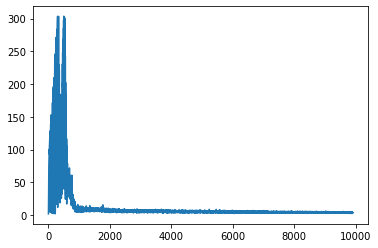

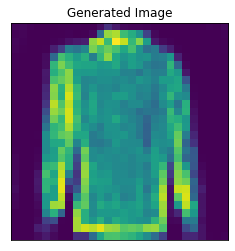

Iteration [9901/10000]......0.115(s) gen: -188.04562 - disc_fake: 188.70466 - disc_real: 192.74251 - disc_real: 4.03785
Iteration [9902/10000]......0.117(s) gen: -189.85088 - disc_fake: 187.31889 - disc_real: 192.26952 - disc_real: 4.95062
Iteration [9903/10000]......0.116(s) gen: -189.10985 - disc_fake: 189.86037 - disc_real: 192.96171 - disc_real: 3.10134
Iteration [9904/10000]......0.116(s) gen: -187.19980 - disc_fake: 189.01793 - disc_real: 192.19430 - disc_real: 3.17638
Iteration [9905/10000]......0.114(s) gen: -187.87488 - disc_fake: 187.49648 - disc_real: 191.30256 - disc_real: 3.80608
Iteration [9906/10000]......0.115(s) gen: -186.25795 - disc_fake: 186.50429 - disc_real: 190.84075 - disc_real: 4.33646
Iteration [9907/10000]......0.117(s) gen: -186.27512 - disc_fake: 187.30388 - disc_real: 191.26566 - disc_real: 3.96178
Iteration [9908/10000]......0.116(s) gen: -186.54971 - disc_fake: 187.37435 - disc_real: 191.47952 - disc_real: 4.10517
Iteration [9909/10000]......0.114(s) gen

Iteration [9970/10000]......0.125(s) gen: -188.37234 - disc_fake: 188.16509 - disc_real: 191.91350 - disc_real: 3.74841
Iteration [9971/10000]......0.122(s) gen: -187.13281 - disc_fake: 187.61825 - disc_real: 192.18307 - disc_real: 4.56483
Iteration [9972/10000]......0.123(s) gen: -188.58563 - disc_fake: 188.15504 - disc_real: 191.95688 - disc_real: 3.80184
Iteration [9973/10000]......0.123(s) gen: -187.97882 - disc_fake: 187.88672 - disc_real: 192.34819 - disc_real: 4.46147
Iteration [9974/10000]......0.126(s) gen: -186.88206 - disc_fake: 188.46379 - disc_real: 192.39757 - disc_real: 3.93378
Iteration [9975/10000]......0.121(s) gen: -189.52808 - disc_fake: 188.31400 - disc_real: 192.56761 - disc_real: 4.25360
Iteration [9976/10000]......0.122(s) gen: -187.18521 - disc_fake: 188.07954 - disc_real: 191.93440 - disc_real: 3.85486
Iteration [9977/10000]......0.123(s) gen: -187.88710 - disc_fake: 189.29230 - disc_real: 193.23347 - disc_real: 3.94117
Iteration [9978/10000]......0.124(s) gen

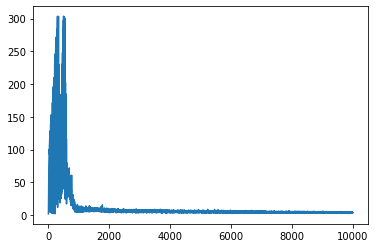

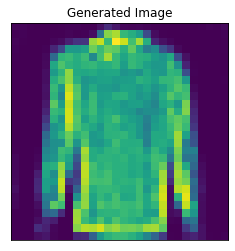

checkpointing at epoch: 10000


In [23]:
import time
from pathlib import Path

start_epoch = 5000
epochs = 10000
batch_size = 64
checkpoint_every_n_epochs = 2000
figure_every_n_epochs = 100
n_critic = 5



plt.ioff()

model_type = f'dragan'
data_name = f'fashion-MNIST'


#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](x_train)
        num_batches = len(training_imgs) // batch_size
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        disc_real_list = []
        disc_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1, latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 
        
        
        disc_real_sum = 0
        disc_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            disc_real, disc_fake = train_step_discriminator(img_batch)
            disc_real_sum += K.get_value(disc_real)
            disc_fake_sum += K.get_value(disc_fake)            
        
        
        
        gen_loss = train_step_generator()
        
        
        
        disc_real = disc_real_sum/n_critic
        disc_fake = disc_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        disc_real_list.append(disc_real)
        disc_fake_list.append(disc_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'disc_fake: {disc_fake:.5f} - ', end='')
        print(f'disc_real: {disc_real:.5f} - ', end='')
        print(f'disc_real: {disc_real - disc_fake:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            
            # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(disc_real_list)-np.array(disc_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(28,28))
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
            discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())
            

In [16]:
generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())

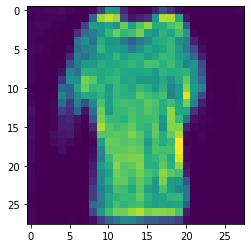

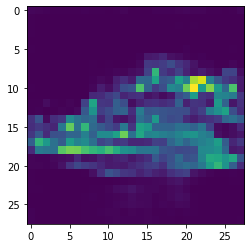

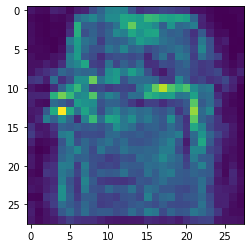

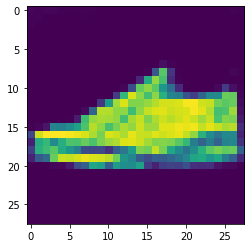

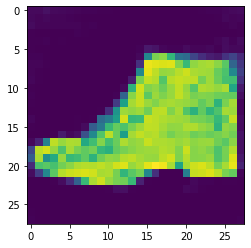

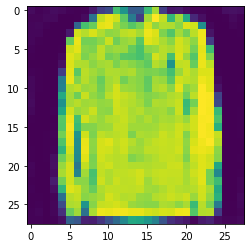

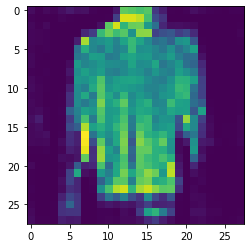

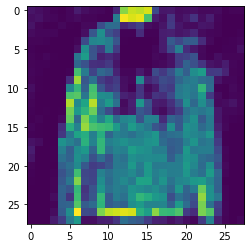

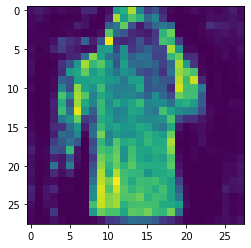

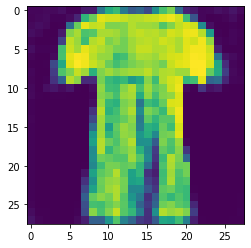

In [25]:
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(28,28))
    plt.show()

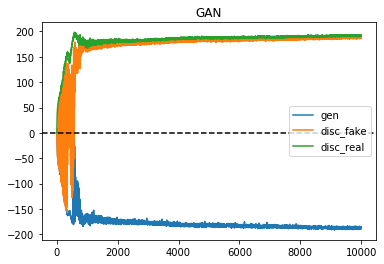

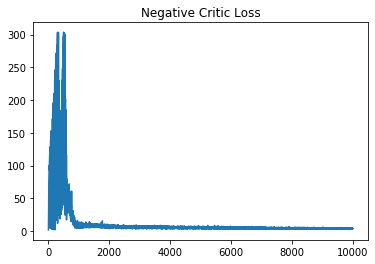

In [26]:
plt.plot(gen_loss_list, label="gen")
plt.plot(disc_fake_list, label="disc_fake")
plt.plot(disc_real_list, label="disc_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(disc_real_list)-np.array(disc_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()